# Database and library installation and setup

### Import libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from textblob import TextBlob
import textstat
import spacy
! python -m spacy download en_core_web_sm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from ast import literal_eval
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

from src.scripts.load_save import *
from src.data.dataprocessing import *
from src.utils.utils import *
%load_ext autoreload
%autoreload 2

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------- ------------------------------ 2.9/12.8 MB 15.3 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 16.1 MB/s eta 0:00:01
     ------------------------------ -------- 10.0/12.8 MB 16.4 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 16.4 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 15.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Database setup

In [36]:
# Load all the CMU datasets
PATH_CMU = 'data/cmu/'
movies, characters, names, plot_summaries, tvtropes = load_datasets(PATH_CMU)

# Load the TMDB dataset
PATH_TMDB = 'data/tmdb/'
tmdb = load_tmdb(PATH_TMDB)
tmdb.columns = ['id', 'Movie name', 'vote_average', 'vote_count' , 'status' , 'release_date' , 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords' , 'net revenue', 'revenue/budget']
tmdb['Extracted Genres'] = tmdb['genres'].apply(str_to_list)
tmdb['Extracted Languages'] = tmdb['spoken_languages'].apply(str_to_list)

In [37]:
GRAPH_COLORS = ['#F8AE54', '#CA6C0F']
GRAPH_EDGECOLOR = '#732E00'

# Histogram of Box Office Revenue

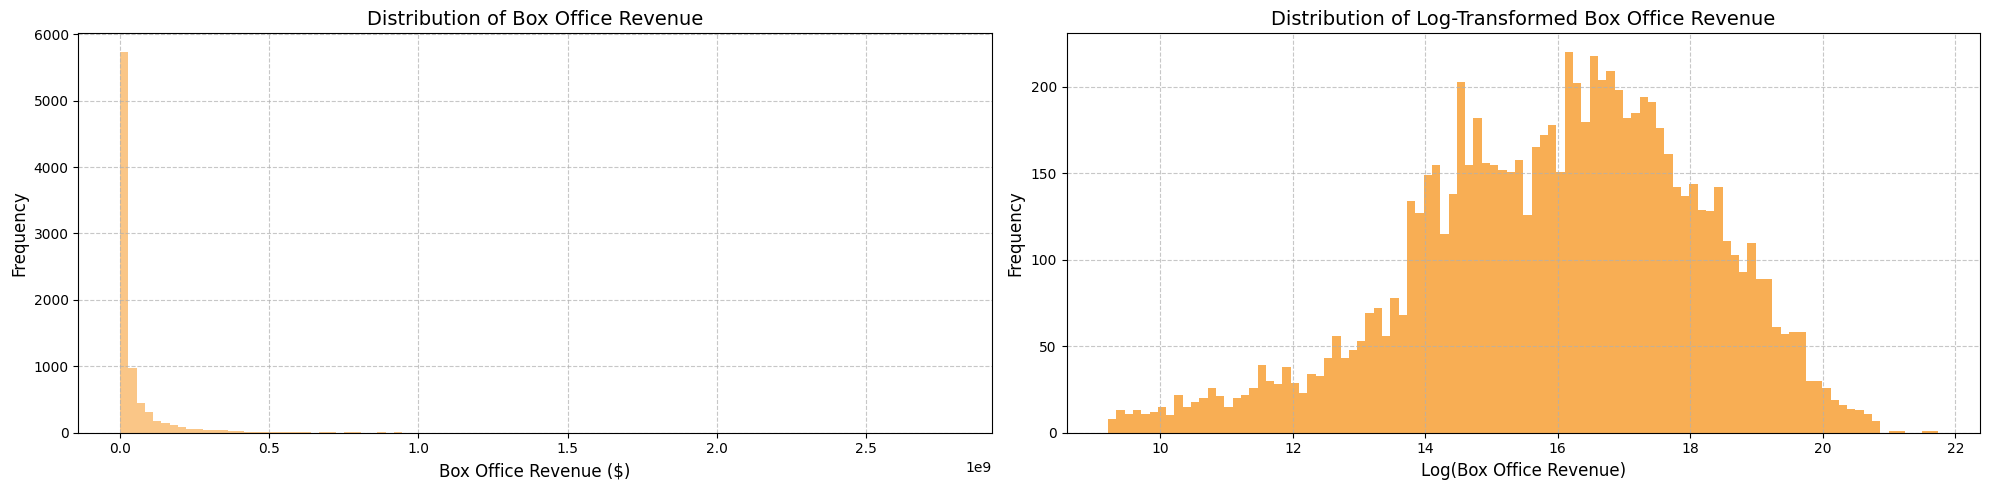

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Original Distribution
axes[0].hist(movies['Movie box office revenue'], bins=100, alpha=0.7, color=GRAPH_COLORS[0])
axes[0].set_title('Distribution of Box Office Revenue', fontsize=14)
axes[0].set_xlabel('Box Office Revenue ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(linestyle='--', alpha=0.7)

# Log-Transformed Distribution
axes[1].hist(np.log1p(movies['Movie box office revenue']), bins=100, color=GRAPH_COLORS[0])
axes[1].set_title('Distribution of Log-Transformed Box Office Revenue', fontsize=14)
axes[1].set_xlabel('Log(Box Office Revenue)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


The histogram of box office revenue, before transformation, shows a highly right-skewed distribution. Most movies earn relatively low revenues, while a small number of blockbuster hits dominate the higher end of the spectrum, creating a long tail. This skewed distribution can make it challenging to observe trends or analyze the majority of the data effectively.

After applying a logarithmic transformation, the distribution becomes more normalized, compressing the range of values. The log-transformed plot reveals a more balanced spread of revenue values, making it easier to analyze the central tendency and variability. This transformation is particularly useful for statistical models, as it mitigates the influence of outliers and ensures better interpretability of relationships between revenue and other features.

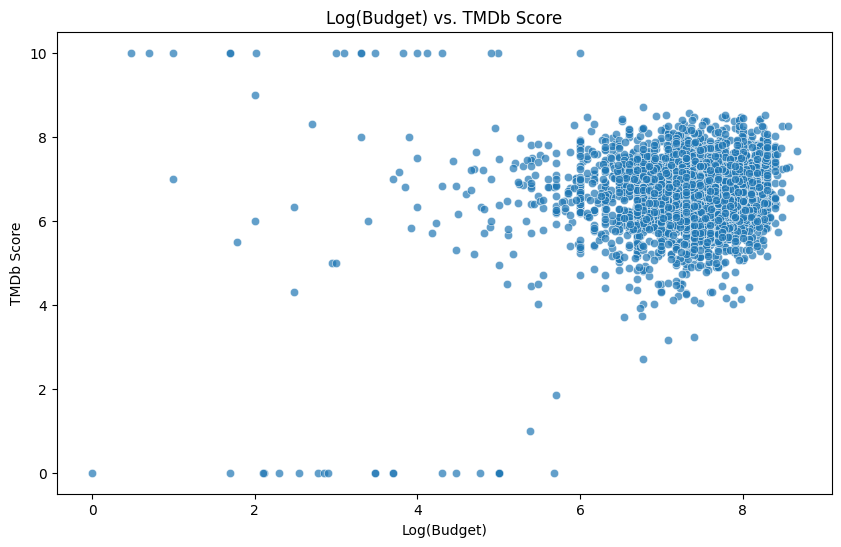

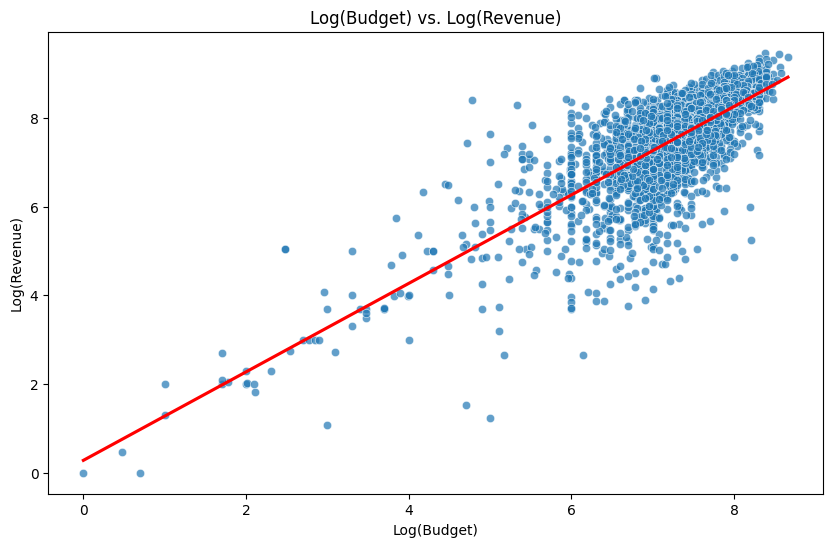

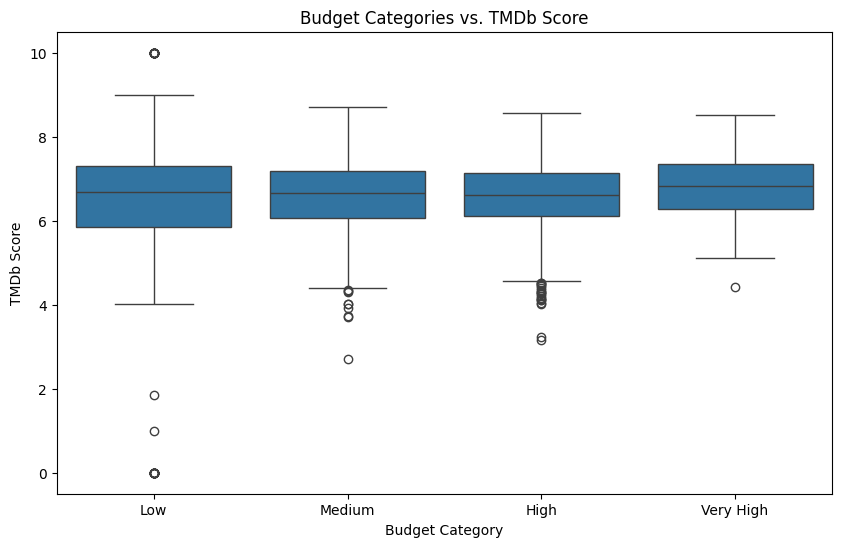

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     33.58
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           7.60e-09
Time:                        18:00:34   Log-Likelihood:                -3951.8
No. Observations:                2756   AIC:                             7908.
Df Residuals:                    2754   BIC:                             7919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5024      0.025    260.108      0.0

In [73]:
# Data Cleaning
tmdb['budget'] = pd.to_numeric(tmdb['budget'], errors='coerce')
tmdb['revenue'] = pd.to_numeric(tmdb['revenue'], errors='coerce')
tmdb['vote_average'] = pd.to_numeric(tmdb['vote_average'], errors='coerce')
tmdb = tmdb.dropna(subset=['budget', 'revenue', 'vote_average'])

# Filter movies with valid non-zero budgets and revenues
tmdb = tmdb[(tmdb['budget'] > 0) & (tmdb['revenue'] > 0)]

# Log-Scale Visualizations
tmdb['log_budget'] = np.log10(tmdb['budget'])
tmdb['log_revenue'] = np.log10(tmdb['revenue'])

# Scatter Plot: Budget vs. TMDb Score (Log Scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tmdb, x='log_budget', y='vote_average', alpha=0.7)
plt.title('Log(Budget) vs. TMDb Score')
plt.xlabel('Log(Budget)')
plt.ylabel('TMDb Score')
plt.show()

# Scatter Plot: Budget vs. Revenue (Log Scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tmdb, x='log_budget', y='log_revenue', alpha=0.7)
sns.regplot(data=tmdb, x='log_budget', y='log_revenue', scatter=False, color='red', ci=None)
plt.title('Log(Budget) vs. Log(Revenue)')
plt.xlabel('Log(Budget)')
plt.ylabel('Log(Revenue)')
plt.show()

# Boxplot: Budget Categories vs. TMDb Score
tmdb['budget_category'] = pd.cut(tmdb['budget'], bins=[0, 1e6, 1e7, 1e8, np.inf], labels=['Low', 'Medium', 'High', 'Very High'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=tmdb, x='budget_category', y='vote_average')
plt.title('Budget Categories vs. TMDb Score')
plt.xlabel('Budget Category')
plt.ylabel('TMDb Score')
plt.show()

# Linear Regression: Budget vs. TMDb Score
X = tmdb[['budget']]
y_score = tmdb['vote_average']
model_score = LinearRegression()
model_score.fit(X, y_score)
score_pred = model_score.predict(X)

# Regression Summary for TMDb Score
X_const = sm.add_constant(tmdb['budget'])
model_score_sm = sm.OLS(tmdb['vote_average'], X_const).fit()
print(model_score_sm.summary())

# Linear Regression: Budget vs. Revenue
X = tmdb[['log_budget']]
y_revenue = tmdb['log_revenue']
model_revenue = LinearRegression()
model_revenue.fit(X, y_revenue)
revenue_pred = model_revenue.predict(X)

# Regression Summary for Revenue
X_const_log = sm.add_constant(tmdb['log_budget'])
model_revenue_sm = sm.OLS(tmdb['log_revenue'], X_const_log).fit()
print(model_revenue_sm.summary())

# R-squared values
print(f"R-squared for Budget vs TMDb Score: {model_score.score(tmdb[['budget']], tmdb['vote_average'])}")
print(f"R-squared for Log(Budget) vs Log(Revenue): {model_revenue.score(tmdb[['log_budget']], tmdb['log_revenue'])}")

# Runtime

#### Scatter Plot

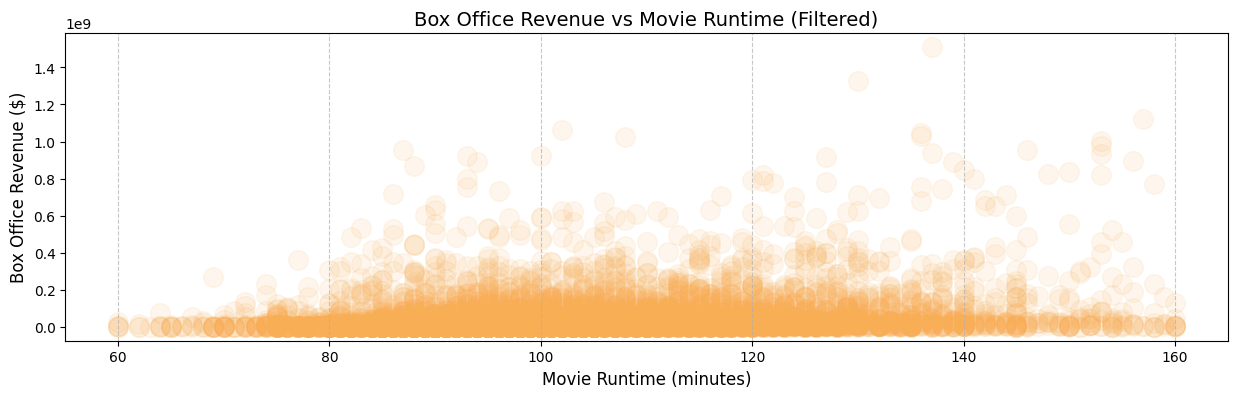

In [39]:
# Filter out movies with runtime > 300 minutes and revenue > 1e9
filtered_movies = movies[(movies['Movie runtime'] <= 160) &
                                 (movies['Movie runtime'] >= 60)]

plt.figure(figsize=(15, 4))
plt.scatter(filtered_movies['Movie runtime'], filtered_movies['Movie box office revenue'], alpha=0.1, s=200, color=GRAPH_COLORS[0])
plt.title('Box Office Revenue vs Movie Runtime (Filtered)', fontsize=14)
plt.xlabel('Movie Runtime (minutes)', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


The scatter plot highlights the relationship between movie runtime and box office revenue for films within the 60 to 160-minute range. Movies with runtimes between 80 and 140 minutes consistently generate revenues from 0 to 200 million dollars, with a dense concentration of moderately successful films. This suggests that this runtime range aligns well with audience preferences for standard-length films.

Films shorter than 80 minutes rarely achieve high box office revenues, indicating that shorter runtimes may not resonate with mainstream audiences or justify large-scale theatrical releases. On the other hand, movies exceeding 140 minutes begin to venture into blockbuster territory, as evident from the increased presence of high-revenue outliers. This suggests that longer runtimes may signal epic storytelling or higher-budget productions, which are often associated with significant box office success.

Overall, the plot suggests that while the 80–140 minute range is a safe zone for consistent performance, pushing past 140 minutes might yield higher returns when paired with the right content and production scale.

#### Analysis

Pearson Correlation Coefficient: 0.22 (p-value: 1.0343e-86)
Spearman Correlation Coefficient: 0.29 (p-value: 3.4180e-154)


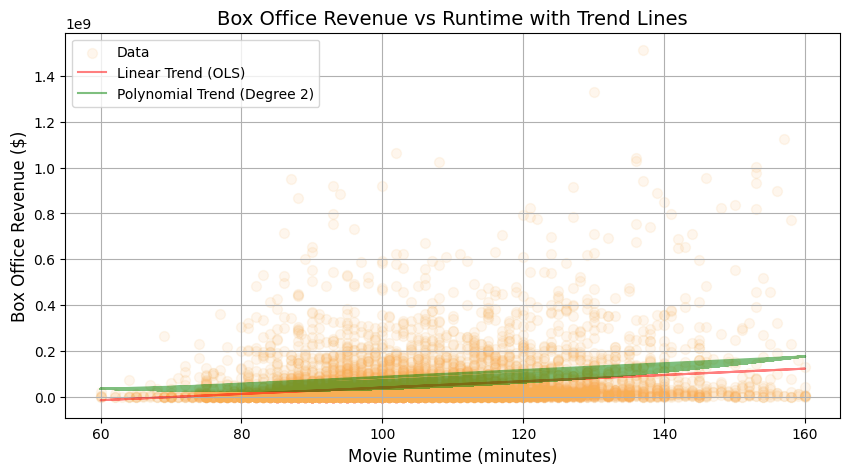

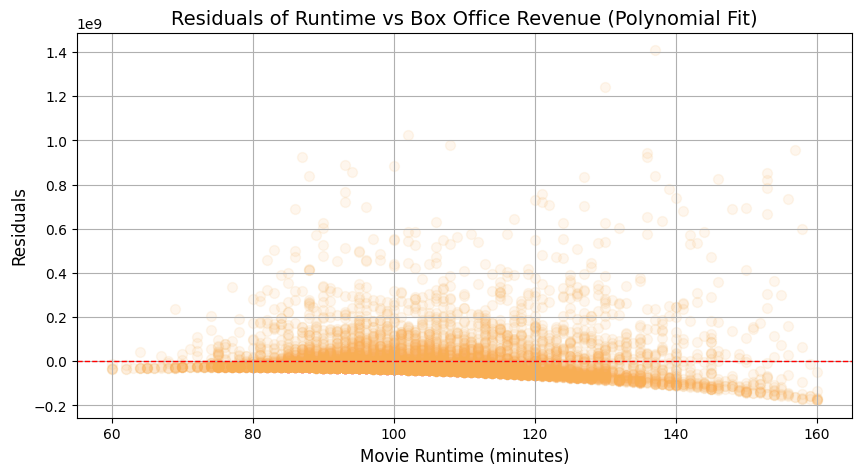

In [40]:
# Calculate Pearson and Spearman correlations
pearson_corr, pearson_p = stats.pearsonr(filtered_movies['Movie runtime'], filtered_movies['Movie box office revenue'])
spearman_corr, spearman_p = stats.spearmanr(filtered_movies['Movie runtime'], filtered_movies['Movie box office revenue'])

# Print results
print(f"Pearson Correlation Coefficient: {pearson_corr:.2f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation Coefficient: {spearman_corr:.2f} (p-value: {spearman_p:.4e})")

# Plotting scatter plot with trend lines
plt.figure(figsize=(10, 5))

# Scatter plot of runtime vs revenue
plt.scatter(filtered_movies['Movie runtime'], filtered_movies['Movie box office revenue'], alpha=0.1, label='Data', color=GRAPH_COLORS[0], s=50)

# Linear regression trend line
X = sm.add_constant(filtered_movies['Movie runtime'])
model = sm.OLS(filtered_movies['Movie box office revenue'], X).fit()
plt.plot(filtered_movies['Movie runtime'], model.predict(X), color='red', alpha=0.5, label='Linear Trend (OLS)')

# Polynomial regression (degree=2) trend line
poly_coefs = np.polyfit(filtered_movies['Movie runtime'], filtered_movies['Movie box office revenue'], deg=2)
poly_fit = np.poly1d(poly_coefs)
plt.plot(filtered_movies['Movie runtime'], poly_fit(filtered_movies['Movie runtime']), alpha=0.5, color='green', label='Polynomial Trend (Degree 2)')

plt.title('Box Office Revenue vs Runtime with Trend Lines', fontsize=14)
plt.xlabel('Movie Runtime (minutes)', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Residuals for Polynomial Fit
plt.figure(figsize=(10, 5))
plt.scatter(filtered_movies['Movie runtime'], 
            filtered_movies['Movie box office revenue'] - poly_fit(filtered_movies['Movie runtime']), 
            alpha=0.1, color=GRAPH_COLORS[0], s=50)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals of Runtime vs Box Office Revenue (Polynomial Fit)', fontsize=14)
plt.xlabel('Movie Runtime (minutes)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid()
plt.show()


1. **Pearson Correlation**:
   - Coefficient: **0.22** (p-value: **1.0343e-86**) indicates a weak positive linear relationship.

2. **Spearman Correlation**:
   - Coefficient: **0.29** (p-value: **3.4180e-154**) suggests a weak but stronger monotonic relationship, indicating non-linearity.

3. **Trend Lines**:
   - Linear regression shows a weak upward trend.
   - Polynomial regression reveals diminishing returns for runtimes beyond 120–140 minutes.

Runtime has a weak but statistically significant influence on revenue. The non-linear trend suggests slight revenue gains with longer runtimes.


# Language

#### Language vs Box Office Revenue (Bar Plot)

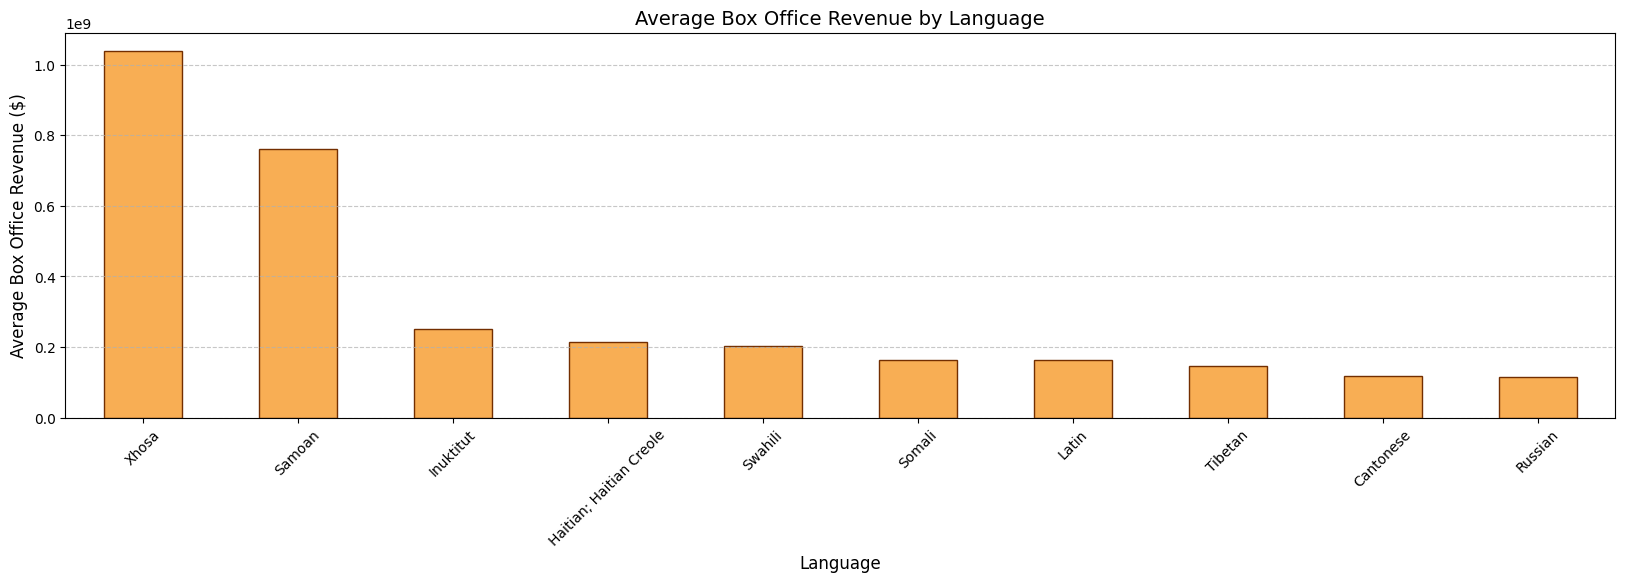

In [41]:
lang = tmdb.explode('Extracted Languages')
lang = lang.dropna(subset=['Extracted Languages'])

# Group and plot
language_revenue = lang.groupby('Extracted Languages')['revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 5))
language_revenue.head(10).plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Average Box Office Revenue by Language', fontsize=14)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The analysis shows that **Xhosa** and **Samoan** appear as the top two languages based on average box office revenue. At first glance, this might suggest that using these languages could significantly enhance a movie's financial success. However, a deeper examination reveals this conclusion is misleading due to the small sample sizes for these languages in the dataset.

For **Xhosa**, there are only seven movies in the dataset that include the language. Among these, two have zero revenue, while the remaining five—**Avengers: Infinity War**, **Avengers: Endgame**, **Black Panther**, **Black Panther: Wakanda Forever**, and **District 9**—are blockbuster hits, disproportionately inflating the average. Similarly, for **Samoan**, there is only one movie in the dataset—**Fast & Furious Presents: Hobbs & Shaw**—a major commercial success.

These examples highlight how small sample sizes can skew results and lead to incorrect interpretations. To address this, we have implemented a limitation on sample size in our analysis, ensuring that insights are drawn from a statistically robust number of observations. This adjustment prevents outliers and anomalies from distorting our conclusions and provides a more accurate reflection of the relationship between language and box office revenue.


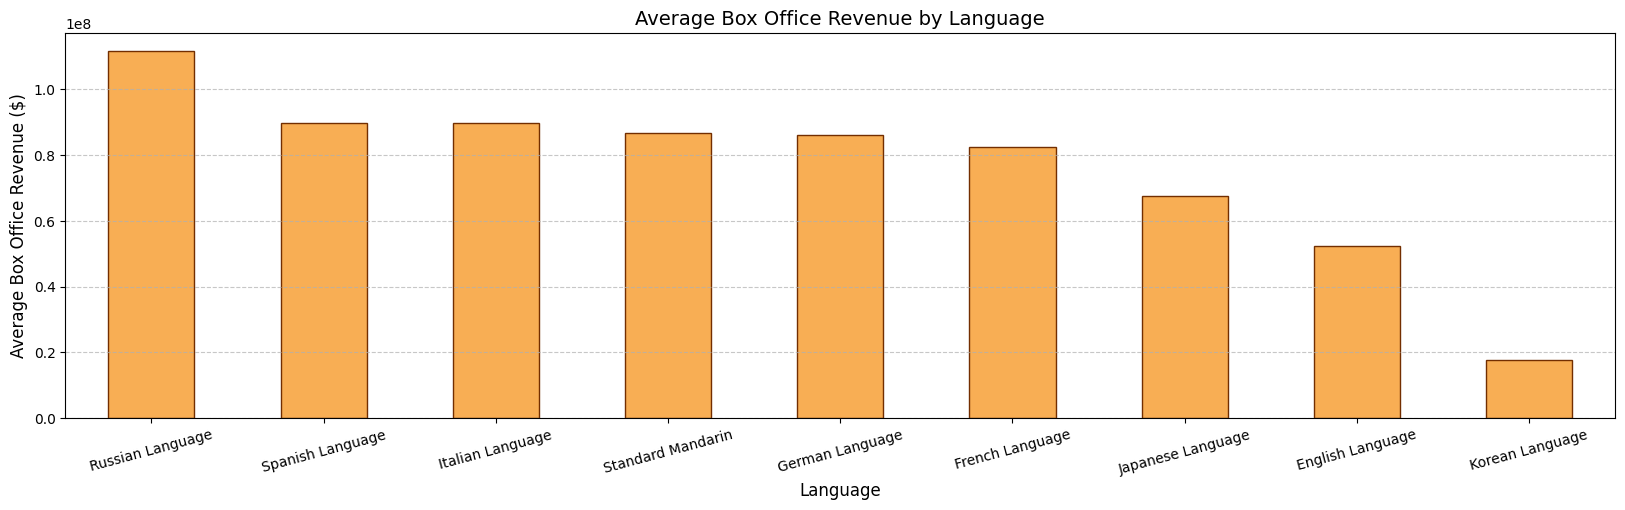

In [42]:
LIMIT_SAMPLE = 100

lang = movies.explode('Extracted Languages')
lang = lang.dropna(subset=['Extracted Languages'])


# Calculate the sample size for each language
language_counts = lang['Extracted Languages'].value_counts()

# Filter languages that meet the minimum sample size
valid_languages = language_counts[language_counts >= LIMIT_SAMPLE].index
filtered_lang = lang[lang['Extracted Languages'].isin(valid_languages)]

# Group and calculate average revenue for valid languages
language_revenue = filtered_lang.groupby('Extracted Languages')['Movie box office revenue'].mean().sort_values(ascending=False)

plt.figure(figsize=(20, 5))
language_revenue.head(10).plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Average Box Office Revenue by Language', fontsize=14)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Month of the year

#### Bar chart for revenue over the year

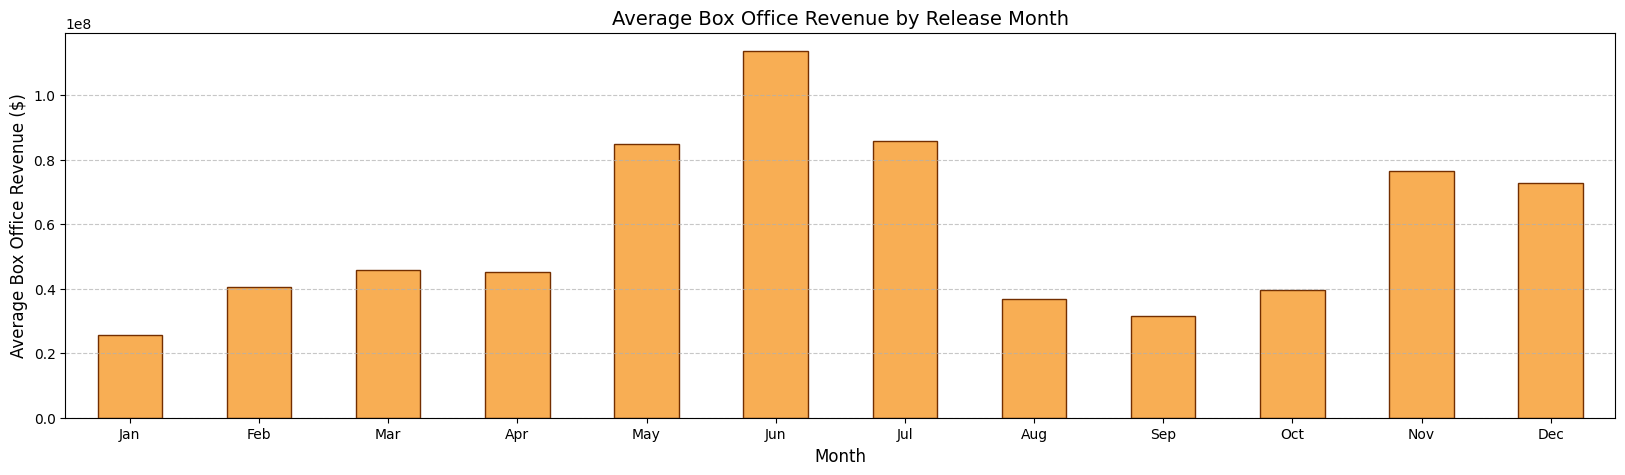

In [43]:
movies_month = movies.copy()
movies_month['Movie release date'] = pd.to_datetime(movies_month['Movie release date'], errors='coerce')
movies_month = movies_month.dropna(subset='Movie release date')
movies_month['Movie release month'] = pd.DatetimeIndex(movies_month['Movie release date']).month

# Group by year or month
monthly_revenue = movies_month.groupby('Movie release month')['Movie box office revenue'].mean()

# Plot
plt.figure(figsize=(20, 5))
monthly_revenue.plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Average Box Office Revenue by Release Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart shows average box office revenue by release month. High-revenue months like May, June, July, November, and December align with blockbuster releases and holiday seasons. Low-revenue months, such as January, February, and September, often feature movies with lower commercial expectations. This highlights the strategic importance of release timing in maximizing box office success.

#### Histogram of quantity of movies released in corresponding month.

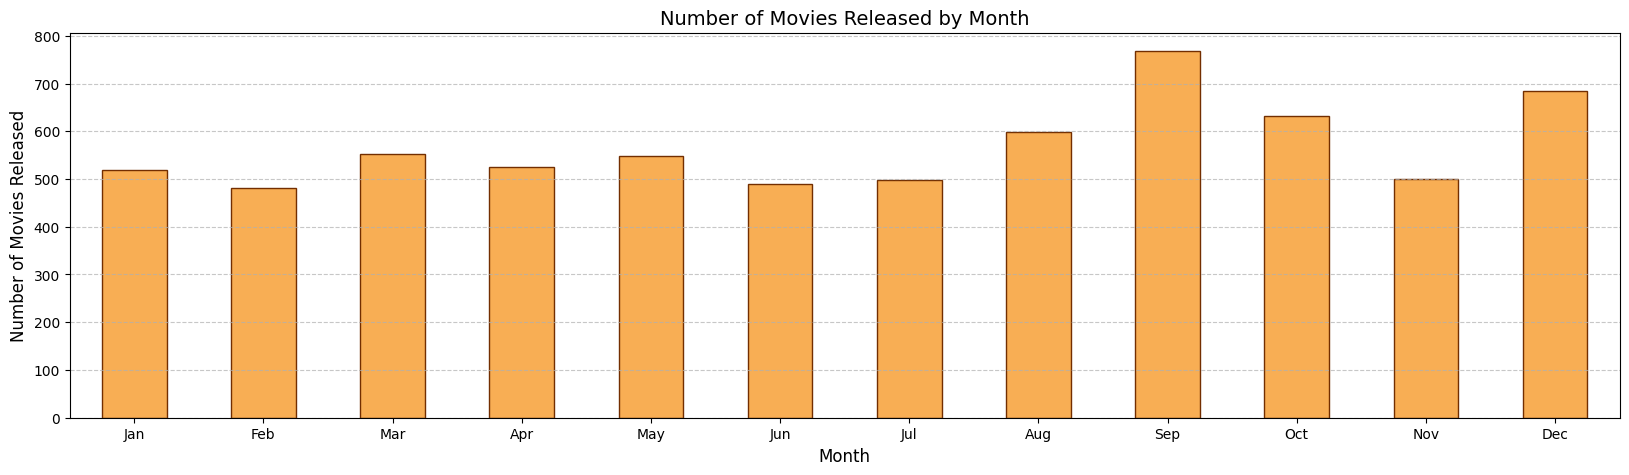

In [44]:
# Group by month and count the number of movies released
monthly_movie_count = movies_month.groupby('Movie release month').size()

# Plot
plt.figure(figsize=(20, 5))
monthly_movie_count.plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Number of Movies Released by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Movies Released', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Genre

#### Histogram using CMU dataset

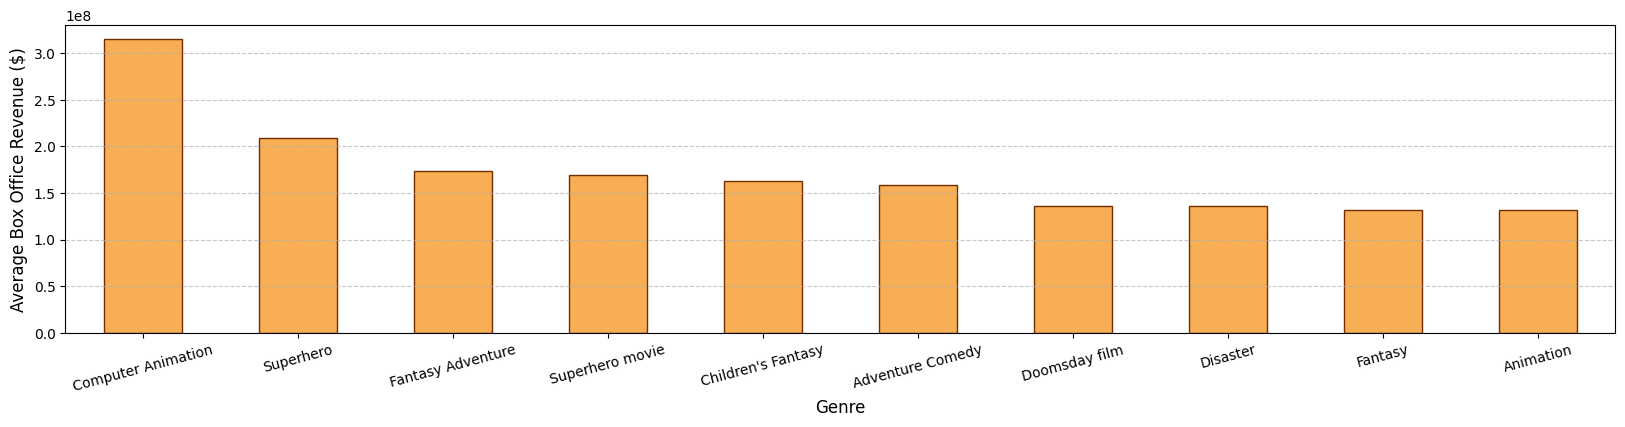

In [45]:
movies_with_genres = movies.explode('Extracted Genres')

genre_revenue = movies_with_genres.groupby('Extracted Genres')['Movie box office revenue'].mean().sort_values(ascending=False)

LIMIT_SAMPLE = 50
genre_counts = movies_with_genres['Extracted Genres'].value_counts()
valid_genres = genre_counts[genre_counts >= LIMIT_SAMPLE].index  

movies_with_valid_genres = movies_with_genres[movies_with_genres['Extracted Genres'].isin(valid_genres)]

genre_revenue = movies_with_valid_genres.groupby('Extracted Genres')['Movie box office revenue'].mean().sort_values(ascending=False)

plt.figure(figsize=(20, 4))
genre_revenue.head(10).plot(kind='bar', alpha=1, color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
# plt.title(f'Top 10 Genres by Average Box Office Revenue (Genres with > {LIMIT_SAMPLE+1} Movies)', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This graph varies heavily on sample size.

#### Histogram revenue

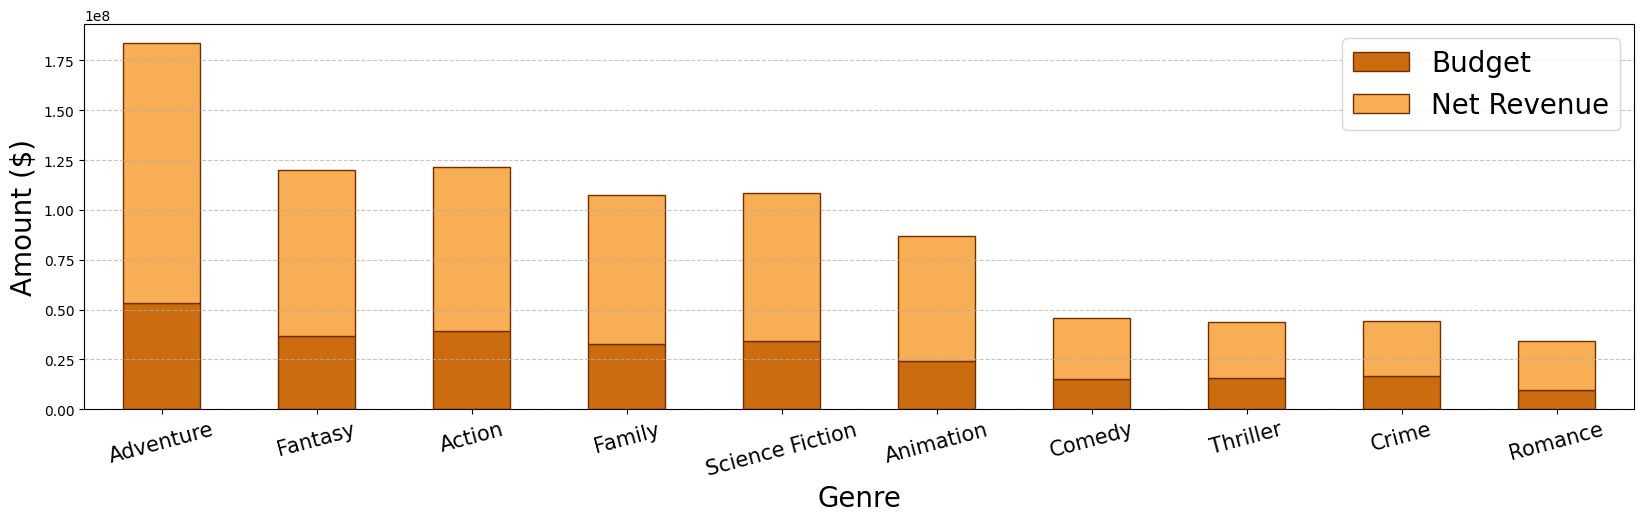

In [46]:
# Columns to show
columns = ['net revenue', 'budget']

# Drop rows with no genres, zero budget, or zero revenue
tmdb_cleaned = tmdb.dropna(subset=['Extracted Genres', columns[0], columns[1]])

# Explode genres into separate rows
tmdb_exploded = tmdb_cleaned.explode('Extracted Genres')

# Group by genre and calculate average budget and net revenue
genre_stats = tmdb_exploded.groupby('Extracted Genres')[[columns[0], columns[1]]].mean().sort_values(by=columns[0], ascending=False)

# Plot the top 10 genres with a stacked bar chart
top_genres = genre_stats.head(10)

# Adjust the stacked bar
fig, ax = plt.subplots(figsize=(20, 5))
top_genres[columns[1]].plot(kind='bar', color=GRAPH_COLORS[1], edgecolor=GRAPH_EDGECOLOR, ax=ax, label=get_capitalized_first_letter(columns[1]), alpha=1)
top_genres[columns[0]].plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, bottom=top_genres[columns[1]], label=get_capitalized_first_letter(columns[0]), alpha=1)

# Customize the plot
# plt.title('Top 10 Genres by Average Revenue and Budget', fontsize=26)
plt.xlabel('Genre', fontsize=20)
plt.ylabel('Amount ($)', fontsize=20)
plt.xticks(fontsize=15, rotation=15)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The data from the TMDB is a lot more representative when it comes to genre vs box office. 
We can see that adventure is at the top with 746 movies and the top 5 are:
- Avatar
- Avangers: End Game
- Avatar: The Way of Water
- Star Wars: The Force Awakens
- Avengers: Infinity War

### Histogram rating

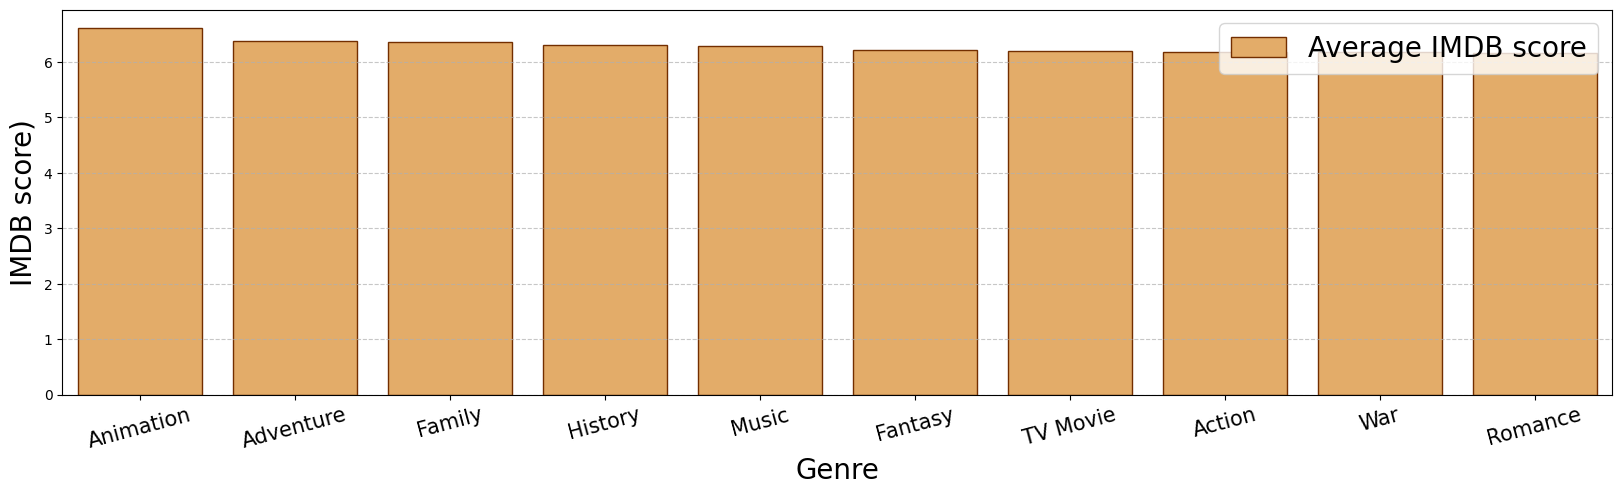

In [47]:
# Columns to show
c = 'vote_average'

# Drop rows with no genres, zero budget, or zero revenue
tmdb_cleaned = tmdb.dropna(subset=['Extracted Genres', 'vote_average'])

# Explode genres into separate rows
tmdb_exploded = tmdb_cleaned.explode('Extracted Genres')

# Group by genre and calculate average budget and net revenue
genre_stats = tmdb_exploded.groupby('Extracted Genres')[['vote_average']].mean().sort_values(by=c, ascending=False)

# Plot the top 10 genres with a stacked bar chart
top_genres = genre_stats.head(10)

# Adjust the stacked bar
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=top_genres.index, y=top_genres['vote_average'], color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, label='Average IMDB score')
# Customize the plot
# plt.title('Top 10 Genres by Average Revenue and Budget', fontsize=26)
plt.xlabel('Genre', fontsize=20)
plt.ylabel('IMDB score)', fontsize=20)
plt.xticks(fontsize=15, rotation=15)
plt.legend(fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Genre Combination

### Histogram revenue

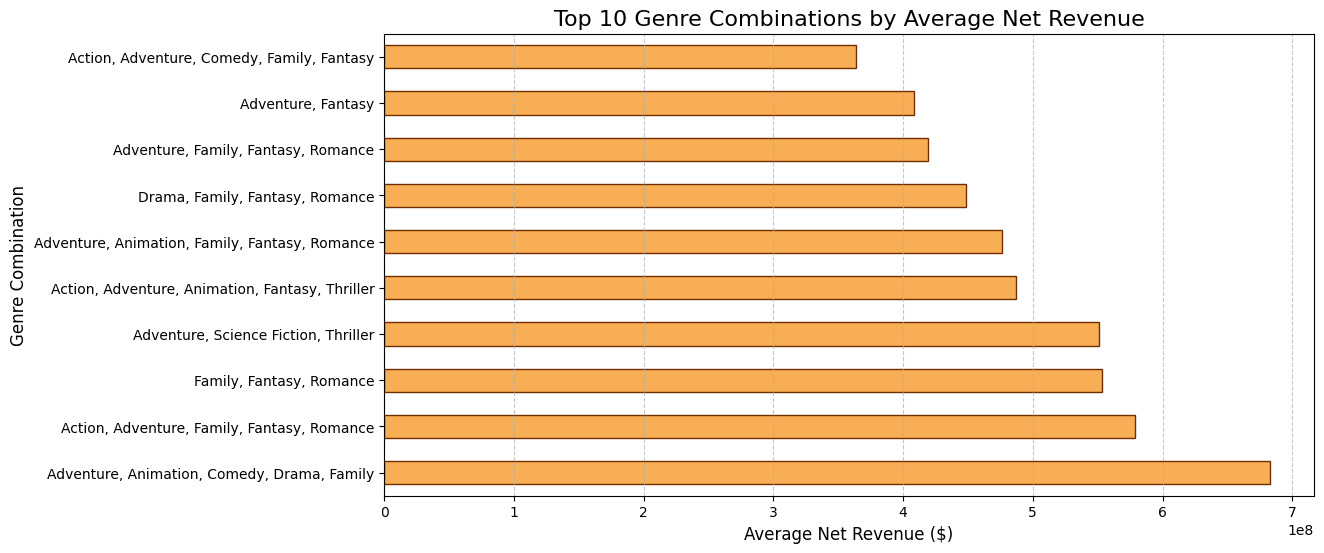

In [48]:
# Count most common genre combinations
tmdb['Genre Combination'] = tmdb['Extracted Genres'].apply(lambda x: ', '.join(sorted(x)))
combination_stats = tmdb.groupby('Genre Combination')['net revenue'].mean().sort_values(ascending=False)

# Plot top 10 genre combinations by average revenue
top_combinations = combination_stats.head(10)
plt.figure(figsize=(12, 6))
top_combinations.plot(kind='barh', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Top 10 Genre Combinations by Average Net Revenue', fontsize=16)
plt.xlabel('Average Net Revenue ($)', fontsize=12)
plt.ylabel('Genre Combination', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Histogram rating

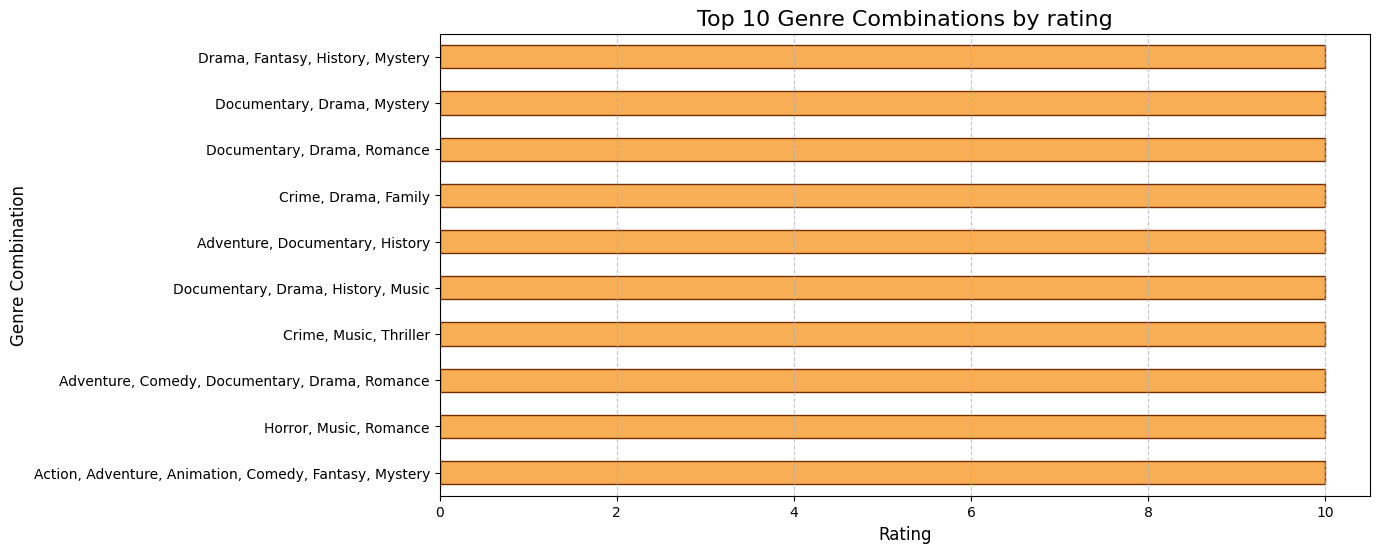

In [49]:
# Count most common genre combinations
tmdb['Genre Combination'] = tmdb['Extracted Genres'].apply(lambda x: ', '.join(sorted(x)))
combination_stats = tmdb.groupby('Genre Combination')['vote_average'].mean().sort_values(ascending=False)

# Plot top 10 genre combinations by average revenue
top_combinations = combination_stats.head(10)
plt.figure(figsize=(12, 6))
top_combinations.plot(kind='barh', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Top 10 Genre Combinations by rating', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Genre Combination', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Number  of Genres

#### Histogram of number of genres and mean revenue

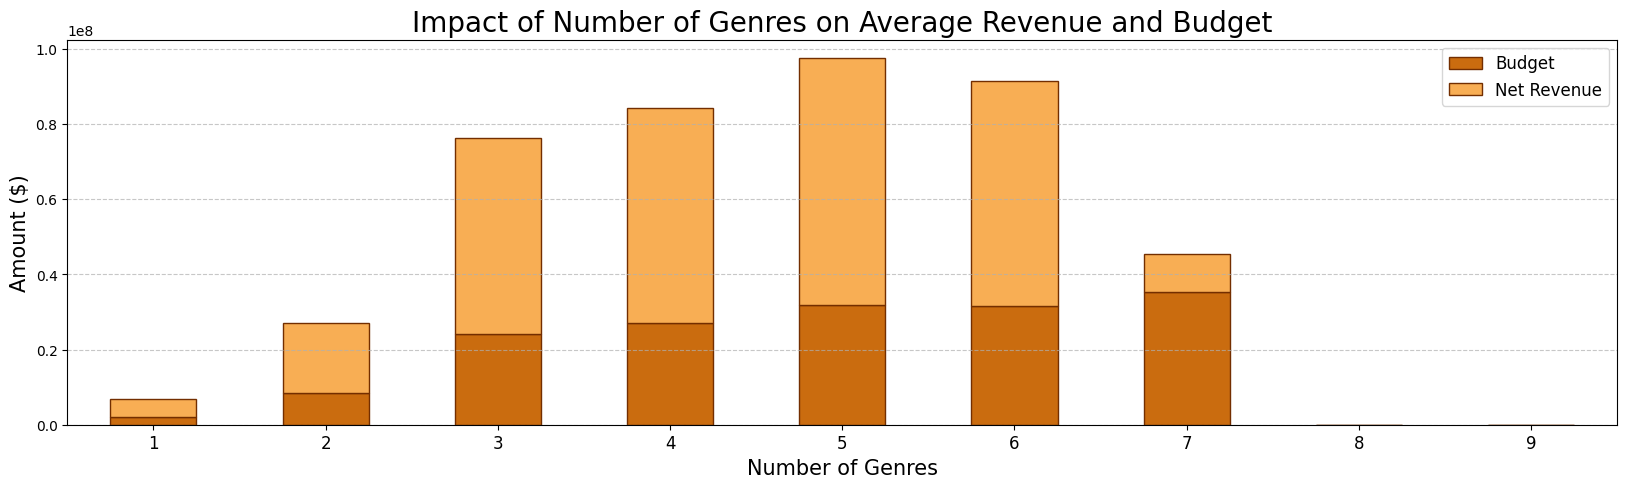

In [50]:
# Calculate the number of genres for each movie
tmdb_cleaned['Number of Genres'] = tmdb_cleaned['Extracted Genres'].apply(len)

# Group by the number of genres and calculate the average net revenue and budget
genre_count_mean = tmdb_cleaned.groupby('Number of Genres')[[columns[0], columns[1]]].mean()

# Plot the average metrics by number of genres
fig, ax = plt.subplots(figsize=(20, 5))
genre_count_mean[columns[1]].plot(kind='bar', color=GRAPH_COLORS[1], edgecolor=GRAPH_EDGECOLOR, ax=ax, label=get_capitalized_first_letter(columns[1]), alpha=1)
genre_count_mean[columns[0]].plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, bottom=genre_count_mean[columns[1]], label=get_capitalized_first_letter(columns[0]), alpha=1)

# Customize the plot
plt.title('Impact of Number of Genres on Average Revenue and Budget', fontsize=20)
plt.xlabel('Number of Genres', fontsize=15)
plt.ylabel('Amount ($)', fontsize=15)
plt.xticks(fontsize=12, rotation=0)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### By revenue

In [51]:
# Count most common genre combinations
tmdb_cleaned['Genre Combination'] = tmdb_cleaned['Extracted Genres'].apply(lambda x: ', '.join(sorted(x)))
combination_stats = tmdb_cleaned.groupby('Genre Combination')[['net revenue', 'budget']].mean().sort_values(by='net revenue', ascending=False)

# Display top combinations
combination_stats.head(10)


,net revenue,budget
Genre Combination,,
"Adventure, Animation, Comedy, Drama, Family",6.826112e+08,1.750000e+08
"Action, Adventure, Family, Fantasy, Romance",5.785398e+08,1.800000e+08
"Family, Fantasy, Romance",5.530580e+08,8.000000e+07
"Adventure, Science Fiction, Thriller",5.511149e+08,1.285000e+08
"Action, Adventure, Animation, Fantasy, Thriller",4.872637e+08,1.580000e+07
"Adventure, Animation, Family, Fantasy, Romance",4.760502e+08,2.800000e+07
"Drama, Family, Fantasy, Romance",4.485144e+08,9.500000e+07
"Adventure, Family, Fantasy, Romance",4.193546e+08,1.676667e+08
"Adventure, Fantasy",4.084297e+08,1.031975e+08


### By rating

In [52]:
# Count most common genre combinations
tmdb_cleaned['Genre Combination'] = tmdb_cleaned['Extracted Genres'].apply(lambda x: ', '.join(sorted(x)))
combination_stats = tmdb_cleaned.groupby('Genre Combination')[['vote_average']].mean().sort_values(by='vote_average', ascending=False)

# Display top combinations
combination_stats.head(10)

,vote_average
Genre Combination,
"Action, Adventure, Animation, Comedy, Fantasy, Mystery",10.0
"Horror, Music, Romance",10.0
"Adventure, Comedy, Documentary, Drama, Romance",10.0
"Crime, Music, Thriller",10.0
"Documentary, Drama, History, Music",10.0
"Adventure, Documentary, History",10.0
"Crime, Drama, Family",10.0
"Documentary, Drama, Romance",10.0
"Documentary, Drama, Mystery",10.0


# Histogram of number of frequency

### By revenue

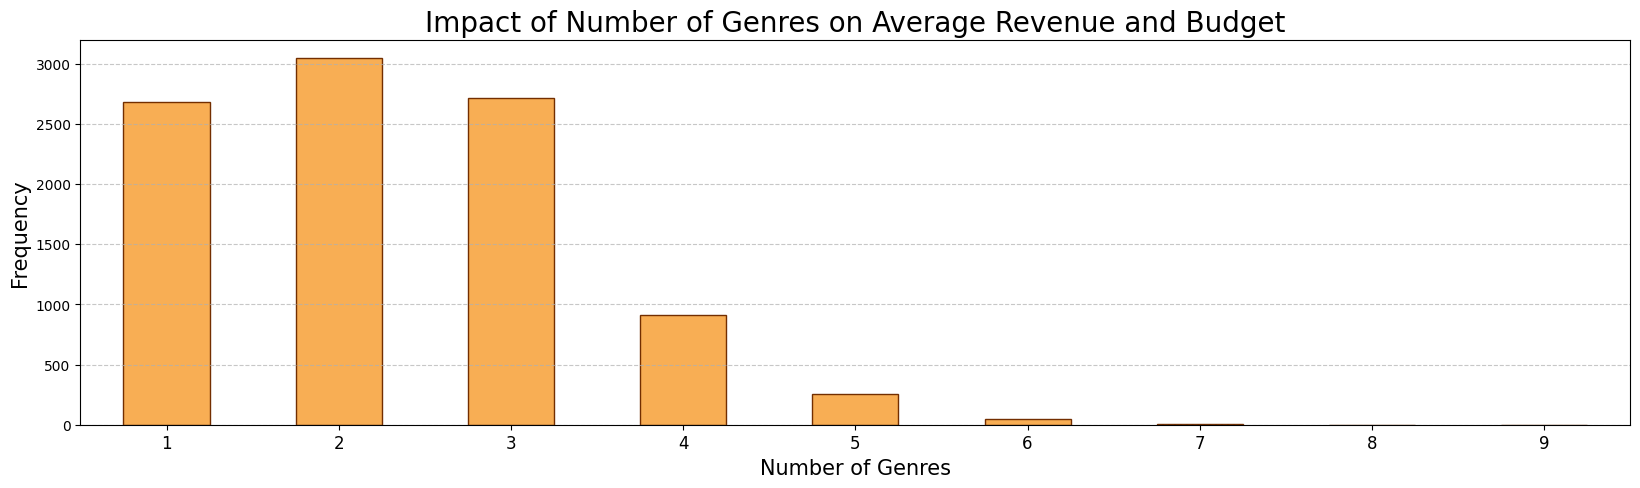

In [53]:
# Calculate the number of genres for each movie
tmdb_cleaned['Number of Genres'] = tmdb_cleaned['Extracted Genres'].apply(len)

# Group by the number of genres and calculate the average net revenue and budget
genre_count_count = tmdb_cleaned.groupby('Number of Genres')[[columns[0], columns[1]]].count()

# Plot the average metrics by number of genres
fig, ax = plt.subplots(figsize=(20, 5))
genre_count_count[columns[1]].plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, label=get_capitalized_first_letter(columns[1]), alpha=1)
# genre_count_count[columns[0]].plot(kind='bar', color=GRAPH_COLOR?S[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, bottom=genre_count_count[columns[1]], label=get_capitalized_first_letter(columns[0]), alpha=1)

# Customize the plot
plt.title('Impact of Number of Genres on Average Revenue and Budget', fontsize=20)
plt.xlabel('Number of Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12, rotation=0)
# plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


1. **Revenue and Budget**:
   - Movies with **3–5 genres** have the highest average revenues and budgets, peaking at **5 genres** (\$65.8M revenue, \$31.8M budget).
   - Movies with **1–2 genres** show significantly lower revenues and budgets, likely indicating smaller-scale productions.
   - Revenues drop for movies with **6+ genres**, likely due to outliers or diminishing returns.

2. **Frequency**:
   - Most movies have **1–3 genres**, with the largest group being **2 genres (3,049 movies)**.
   - Movies with **4–5 genres** are less common but tend to generate higher revenues and budgets.
   - Movies with **6+ genres** are rare and may not represent reliable trends.

3. **Key Insight**:
   - The **sweet spot** for maximizing revenue and budget lies in movies with **3–5 genres**, balancing broader appeal with manageable scope.


### By rating

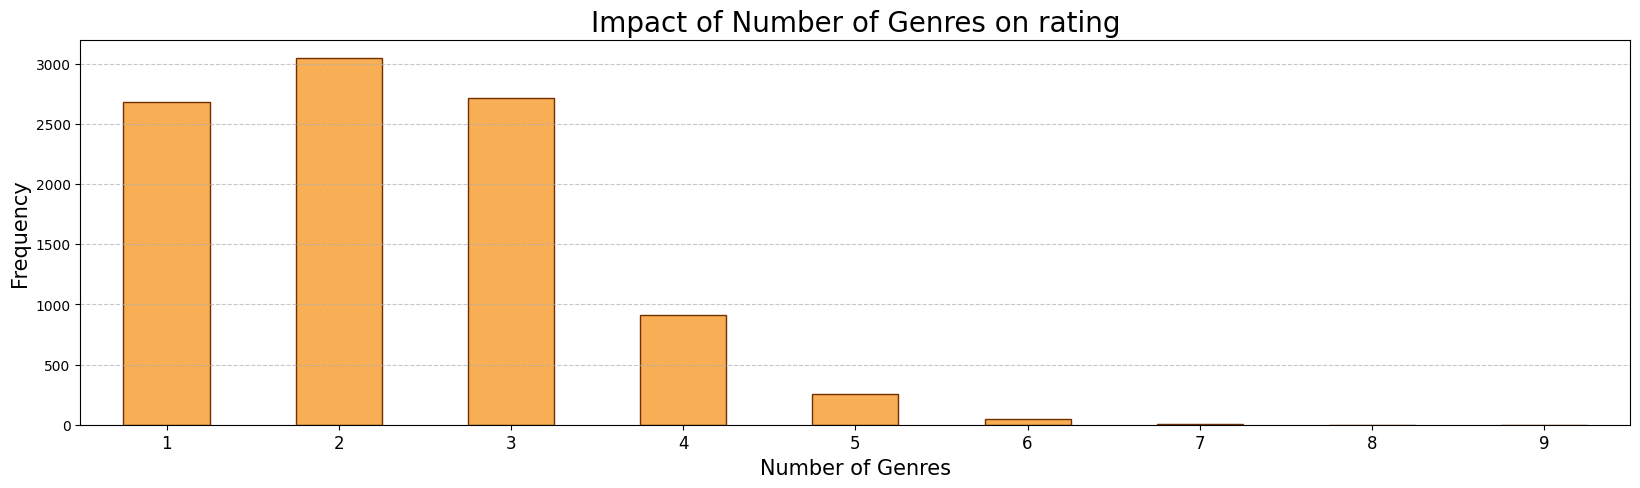

In [54]:
# Calculate the number of genres for each movie
tmdb_cleaned['Number of Genres'] = tmdb_cleaned['Extracted Genres'].apply(len)

# Group by the number of genres and calculate the average net revenue and budget
genre_count_count = tmdb_cleaned.groupby('Number of Genres')[['vote_average']].count()

# Plot the average metrics by number of genres
fig, ax = plt.subplots(figsize=(20, 5))
genre_count_count['vote_average'].plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, label=get_capitalized_first_letter('vote_average'), alpha=1)
# genre_count_count[columns[0]].plot(kind='bar', color=GRAPH_COLOR?S[0], edgecolor=GRAPH_EDGECOLOR, ax=ax, bottom=genre_count_count[columns[1]], label=get_capitalized_first_letter(columns[0]), alpha=1)

# Customize the plot
plt.title('Impact of Number of Genres on rating', fontsize=20)
plt.xlabel('Number of Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12, rotation=0)
# plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Actor Age

#### Age vs Runtime scatter plot

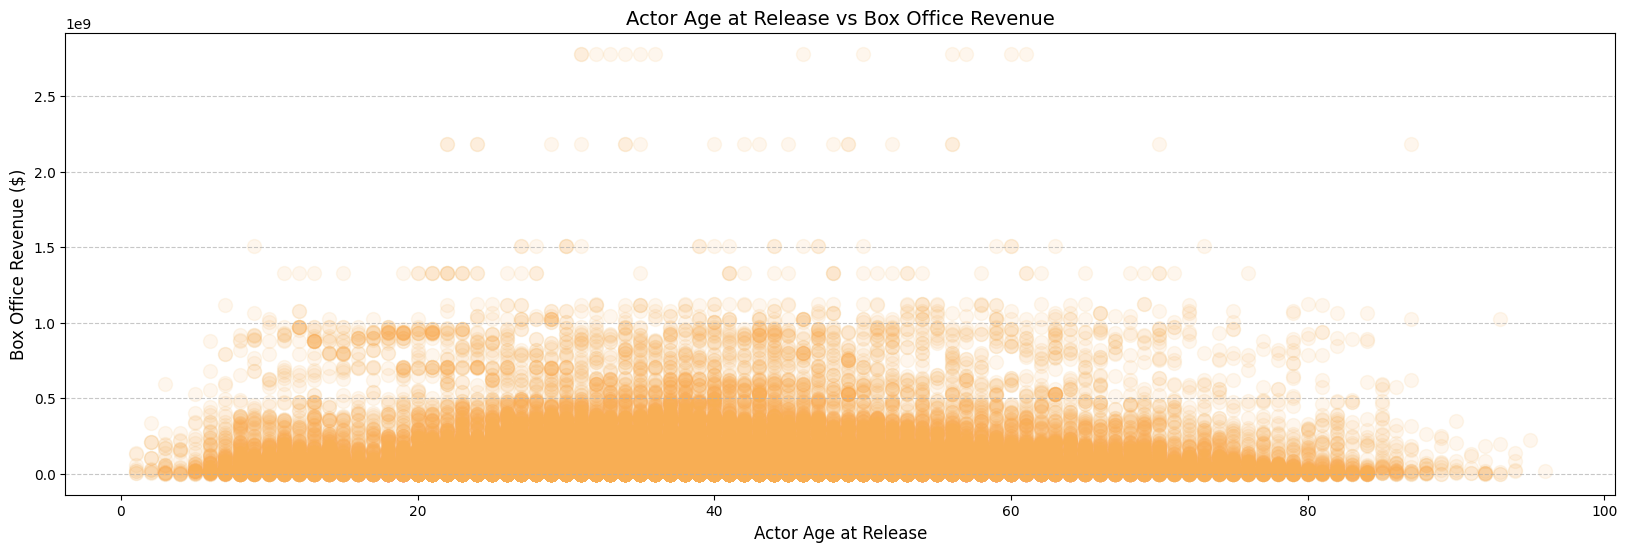

In [55]:
# Merge the two DataFrames on 'Wikipedia movie ID'
age = pd.merge(characters, movies[['Wikipedia movie ID', 'Movie box office revenue']], on='Wikipedia movie ID', how='inner')

# Drop rows with NaN values in the relevant columns
age = age.dropna(subset=['Actor age at movie release', 'Movie box office revenue'])

# Drop rows where actor age is <= 0
age = age[age['Actor age at movie release'] > 0]

plt.figure(figsize=(20, 6))
plt.scatter(age['Actor age at movie release'], age['Movie box office revenue'], alpha=0.1, color=GRAPH_COLORS[0], s=100)
plt.title('Actor Age at Release vs Box Office Revenue', fontsize=14)
plt.xlabel('Actor Age at Release', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


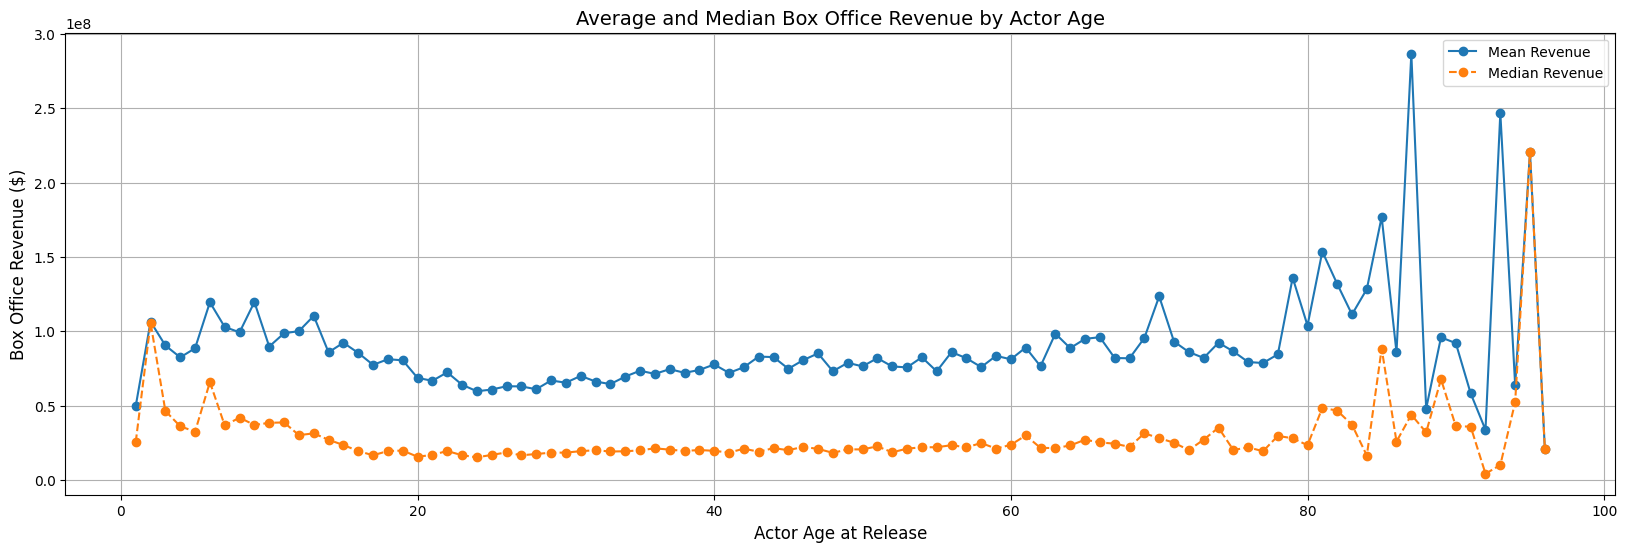

In [56]:
# Group by Actor Age and calculate average and median revenue
age_revenue = age.groupby('Actor age at movie release')['Movie box office revenue'].agg(['mean', 'median']).reset_index()

# Plot Average Revenue by Actor Age
plt.figure(figsize=(20, 6))
plt.plot(age_revenue['Actor age at movie release'], age_revenue['mean'], label='Mean Revenue', marker='o')
plt.plot(age_revenue['Actor age at movie release'], age_revenue['median'], label='Median Revenue', marker='o', linestyle='--')
plt.title('Average and Median Box Office Revenue by Actor Age', fontsize=14)
plt.xlabel('Actor Age at Release', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.legend()
plt.grid()
plt.show()


C:\Users\liess\AppData\Local\Temp\ipykernel_62688\4041003511.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_revenue = age.groupby('Age Group')['Movie box office revenue'].agg(['mean', 'median', 'count'])


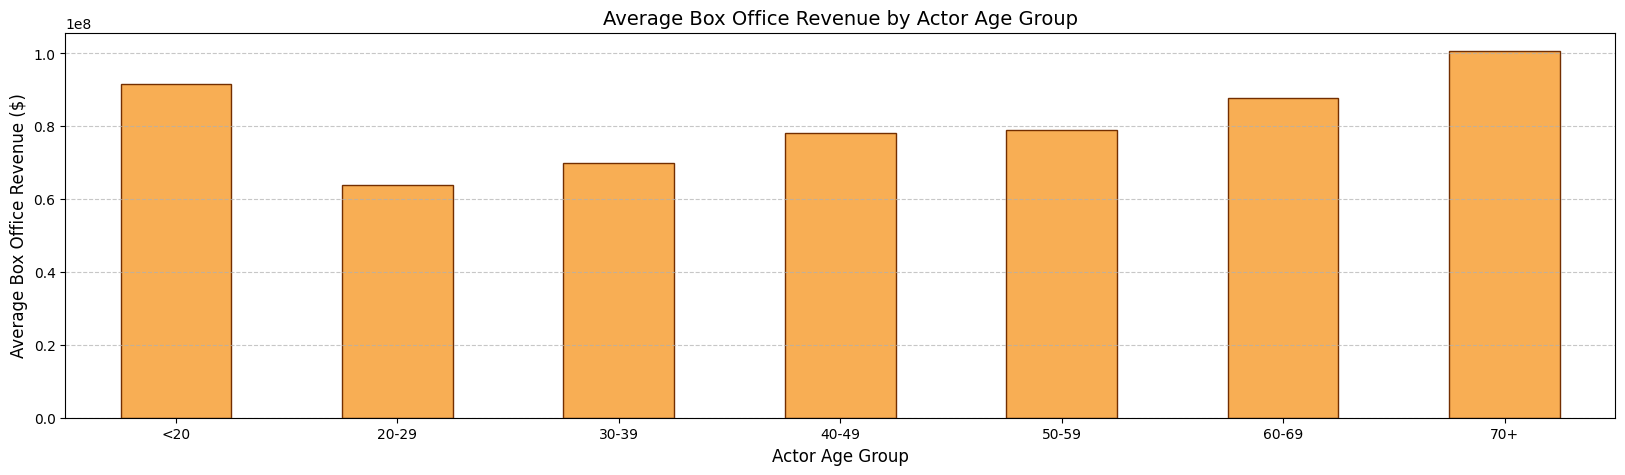

In [57]:
# Create Age Groups
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
age['Age Group'] = pd.cut(age['Actor age at movie release'], bins=bins, labels=labels, right=False)

# Group by Age Group and calculate revenue statistics
grouped_revenue = age.groupby('Age Group')['Movie box office revenue'].agg(['mean', 'median', 'count'])

# Plot Average Revenue by Age Group
plt.figure(figsize=(20, 5))
grouped_revenue['mean'].plot(kind='bar', color=GRAPH_COLORS[0], edgecolor=GRAPH_EDGECOLOR)
plt.title('Average Box Office Revenue by Actor Age Group', fontsize=14)
plt.xlabel('Actor Age Group', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


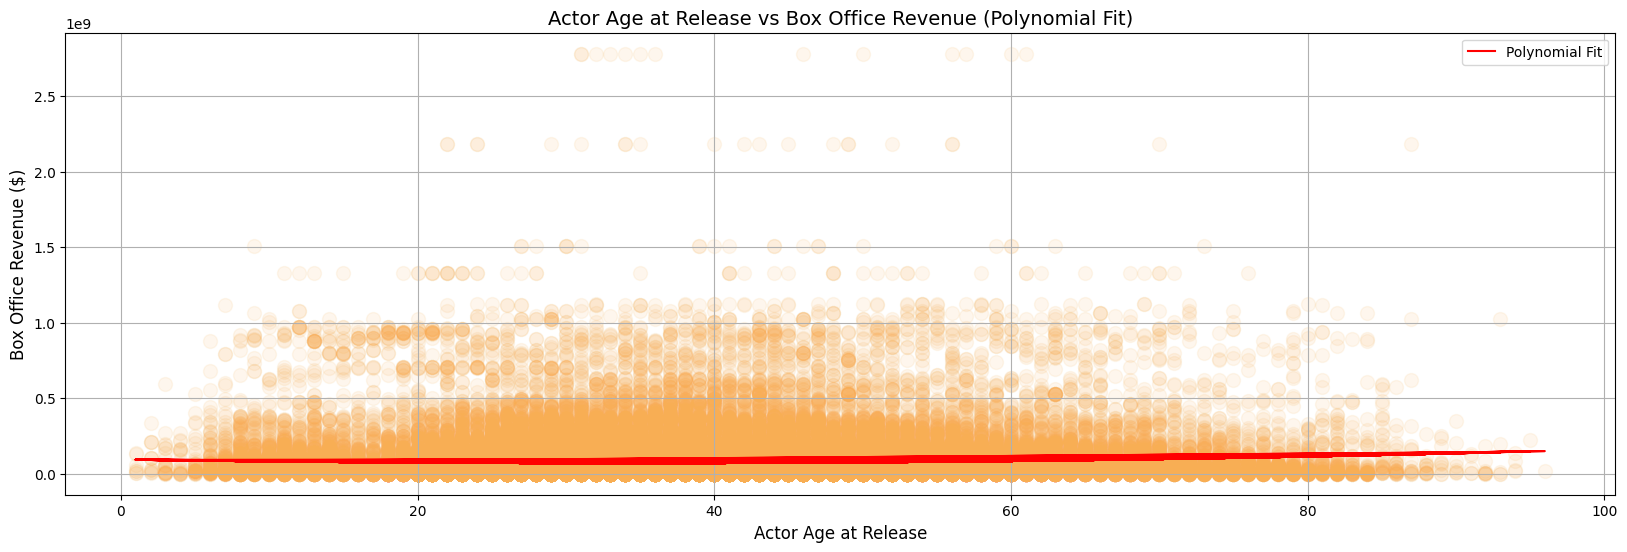

In [58]:
# Fit a Polynomial Regression (Degree=2)
poly_coefs = np.polyfit(age['Actor age at movie release'], age['Movie box office revenue'], deg=2)
poly_fit = np.poly1d(poly_coefs)

# Plot Polynomial Regression
plt.figure(figsize=(20, 6))
plt.scatter(age['Actor age at movie release'], age['Movie box office revenue'], alpha=0.1, s=100, color=GRAPH_COLORS[0])
plt.plot(age['Actor age at movie release'], poly_fit(age['Actor age at movie release']), color='red', label='Polynomial Fit')
plt.title('Actor Age at Release vs Box Office Revenue (Polynomial Fit)', fontsize=14)
plt.xlabel('Actor Age at Release', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [59]:
# Calculate Pearson and Spearman correlations
pearson_corr, pearson_p = stats.pearsonr(age['Actor age at movie release'], age['Movie box office revenue'])
spearman_corr, spearman_p = stats.spearmanr(age['Actor age at movie release'], age['Movie box office revenue'])

# Print results
print(f"Pearson Correlation Coefficient: {pearson_corr:.2f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation Coefficient: {spearman_corr:.2f} (p-value: {spearman_p:.4e})")


Pearson Correlation Coefficient: 0.03 (p-value: 3.1615e-20)
Spearman Correlation Coefficient: 0.04 (p-value: 1.7175e-30)


1. **Correlation Analysis**:
   - **Pearson Correlation Coefficient**: 0.03 (p-value: 3.1615e-20) shows a very weak linear relationship between actor age and box office revenue.
   - **Spearman Correlation Coefficient**: 0.04 (p-value: 1.7175e-30) indicates a similarly weak monotonic relationship.
   - Both correlations are statistically significant due to the large sample size but lack practical significance.

2. **Grouped Revenue**:
   - Actors aged **70+** are associated with the highest average revenue (\$100.7M), followed by those aged **<20** (\$91.7M) and **60-69** (\$87.8M).
   - Median revenues follow a similar pattern, suggesting older and younger actors may appear in films with higher box office appeal.
   - Actors aged **20-29** and **30-39**, despite having the largest number of roles, show lower average revenues, potentially reflecting the volume of mid-budget films featuring this demographic.

3. **General Trends**:
   - While older and younger actors are linked to higher revenues, the relationships are weak.

# Actor Gender

Actor gender
F    6.557150e+07
M    7.391787e+07
Name: Movie box office revenue, dtype: float64


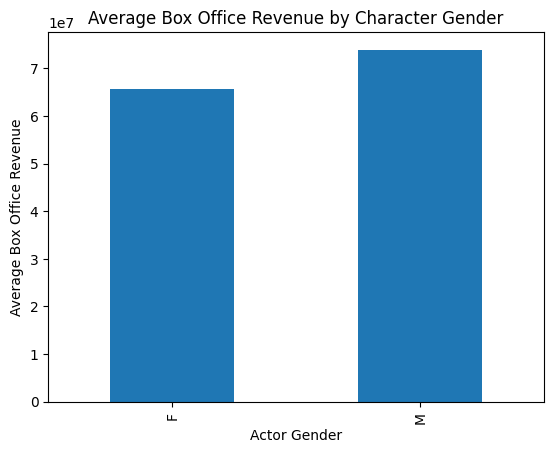

In [60]:
# Merge movies and characters data on 'Wikipedia movie ID'
characters_gender = pd.merge(movies, characters, on='Wikipedia movie ID')
characters_gender = characters_gender.dropna(subset=['Actor gender', 'Movie box office revenue'])

# Group by Actor gender and calculate mean box office revenue
gender_box_office = characters_gender.groupby('Actor gender')['Movie box office revenue'].mean()

# Display the correlation results
print(gender_box_office)

# Plot
gender_box_office.plot(kind='bar')
plt.title('Average Box Office Revenue by Character Gender')
plt.xlabel('Actor Gender')
plt.ylabel('Average Box Office Revenue')
plt.show()


# Countries

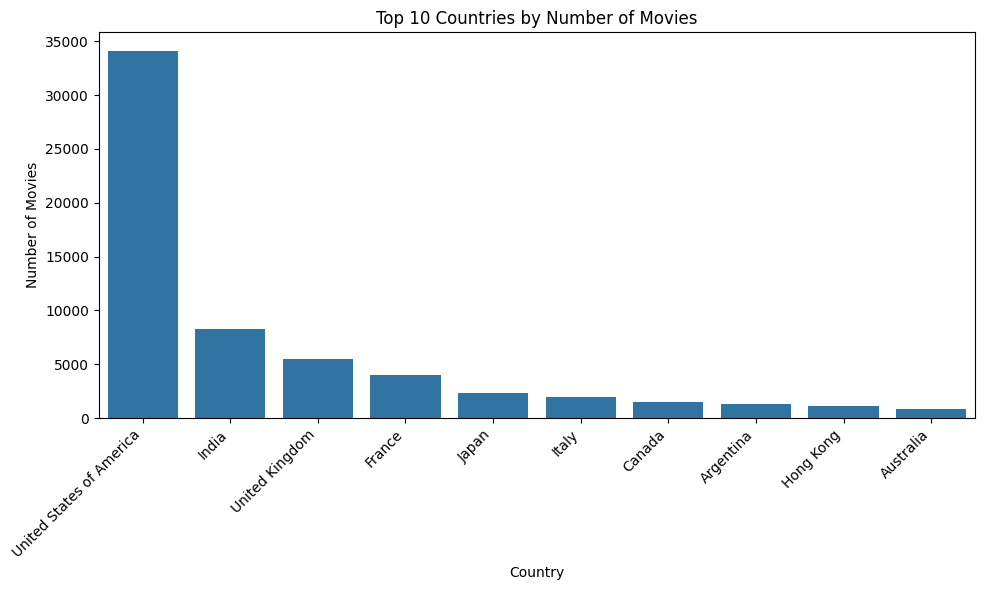

In [61]:
# Load the data
PATH = 'data/cmu/'
movies_metadata = pd.read_csv(PATH + 'movie.metadata.tsv', sep='\t', header=None)
movies_metadata.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']

# Drop rows with empty or NaN values in the 'Movie countries' column
movies_metadata = movies_metadata[movies_metadata['Movie countries'] != '{}']

# Extract just the country names
movies_metadata['Movie countries'] = movies_metadata['Movie countries'].apply(lambda x: list(eval(x).values())[0])

# Calculate the number of movies per country
country_counts = movies_metadata['Movie countries'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Number of Movies")
plt.title("Top 10 Countries by Number of Movies")
plt.tight_layout()
plt.show()

# Sentiment Summary Analysis

In [62]:
# Merge datasets on 'Wikipedia movie ID'
plot_merge = movies.merge(plot_summaries, on='Wikipedia movie ID', how='inner')
plot_merge['Movie box office revenue'] = pd.to_numeric(plot_merge['Movie box office revenue'], errors='coerce')
plot_merge = plot_merge.dropna(subset=['Movie box office revenue', 'Plot'])


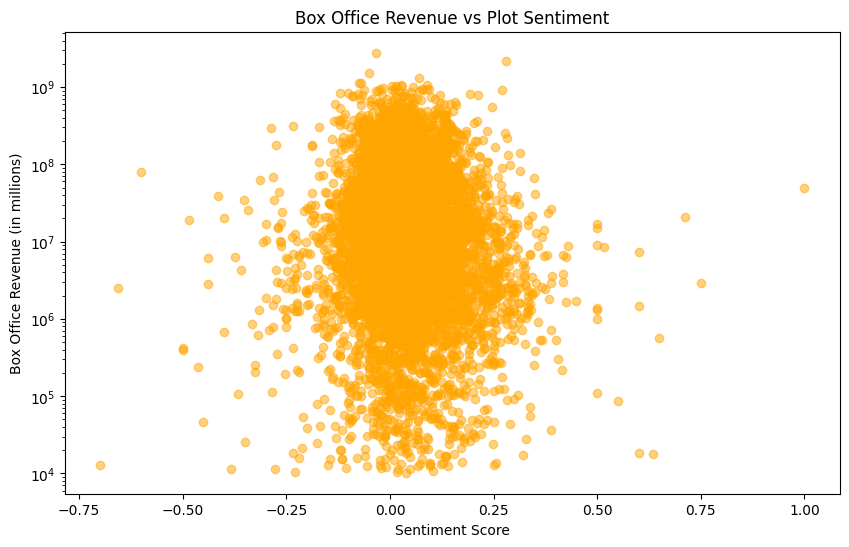

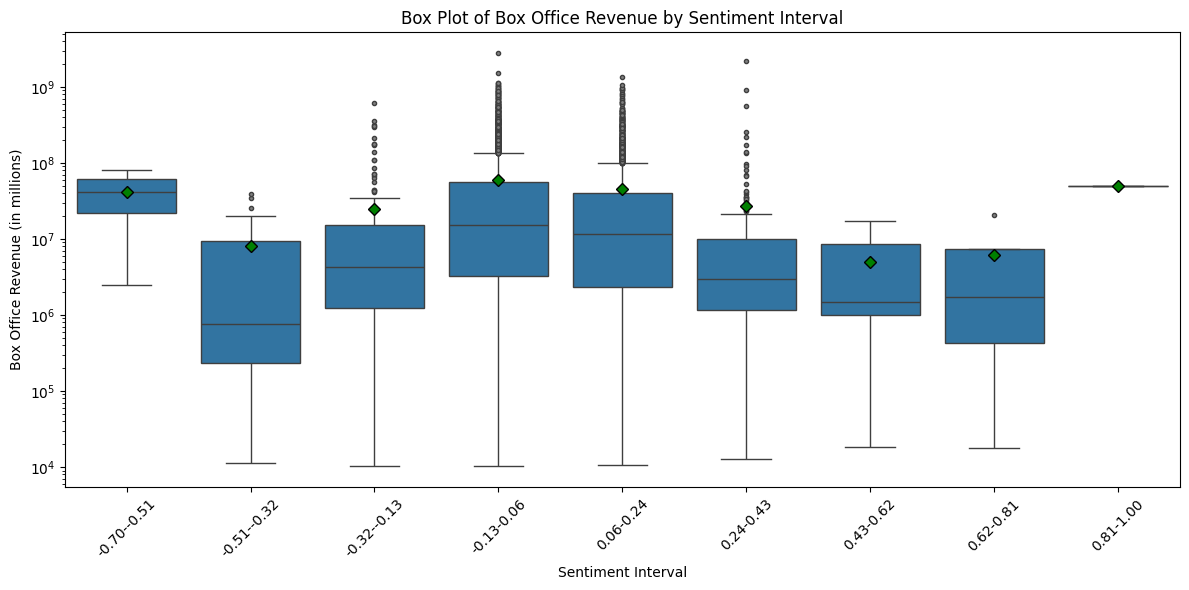

In [63]:
# TF-IDF vectorization for plot summaries
vectorizer = TfidfVectorizer(max_features=500)
plot_tfidf = vectorizer.fit_transform(plot_merge['Plot'])

# Add sentiment score as a feature
plot_merge['sentiment'] = plot_merge['Plot'].apply(lambda plot: TextBlob(plot).sentiment.polarity)

# Extract year from release date
plot_merge['release_year'] = pd.to_datetime(plot_merge['Movie release date'], errors='coerce').dt.year

# Extract genres as separate dummy variables
plot_merge['Extracted Genres'] = plot_merge['Movie genres'].apply(lambda x: [g.split(':')[-1] for g in x.strip('{}').split(', ')])
genres = plot_merge['Extracted Genres'].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum()
plot_merge_genre = pd.concat([plot_merge, genres], axis=1)

# Scatter plot of sentiment vs revenue
plt.figure(figsize=(10, 6))
plt.scatter(plot_merge_genre['sentiment'], plot_merge_genre['Movie box office revenue'], alpha=0.5, color='orange')
plt.title('Box Office Revenue vs Plot Sentiment')
plt.xlabel('Sentiment Score')
plt.ylabel('Box Office Revenue (in millions)')
plt.yscale('log')
plt.show()

# Define sentiment intervals
intervals = np.linspace(plot_merge_genre['sentiment'].min(), plot_merge_genre['sentiment'].max(), num=10)
interval_labels = [f'{intervals[i]:.2f}-{intervals[i+1]:.2f}' for i in range(len(intervals)-1)]

# Assign each row to an interval
plot_merge_genre['sentiment_interval'] = pd.cut(plot_merge_genre['sentiment'], bins=intervals, labels=interval_labels)

# Initialize the plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='sentiment_interval', 
    y='Movie box office revenue', 
    data=plot_merge_genre, 
    showmeans=True, 
    meanprops={"marker": "D", "markerfacecolor": "green", "markeredgecolor": "black"},
    flierprops={"marker": "o", "markerfacecolor": "gray", "markersize": 3, "linestyle": "none"}
)

# Customize the plot
plt.title('Box Plot of Box Office Revenue by Sentiment Interval')
plt.xlabel('Sentiment Interval')
plt.ylabel('Box Office Revenue (in millions)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()


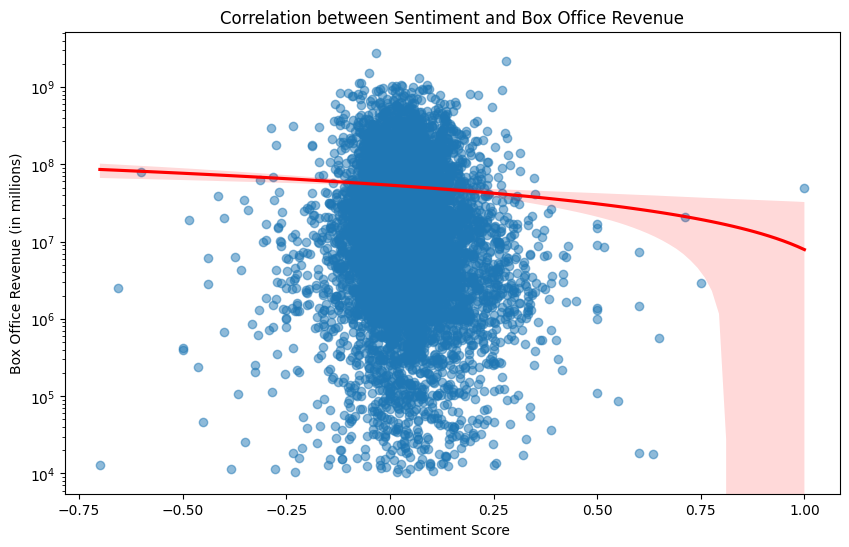

Correlation between Sentiment and Box Office Revenue: -0.04


In [64]:
# Correlation analysis
plt.figure(figsize=(10, 6))
sns.regplot(x='sentiment', y='Movie box office revenue', data=plot_merge_genre, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title('Correlation between Sentiment and Box Office Revenue')
plt.xlabel('Sentiment Score')
plt.ylabel('Box Office Revenue (in millions)')
plt.yscale('log')  # Optional, depending on data range
plt.show()

correlation = plot_merge_genre['sentiment'].corr(plot_merge_genre['Movie box office revenue'])
print(f"Correlation between Sentiment and Box Office Revenue: {correlation:.2f}")


This analysis explores the relationship between movie plot sentiment and box office revenue to determine if positive or negative sentiments impact financial success. The scatter plot and a correlation coefficient of approximately −0.04 reveal a negligible, slightly negative relationship, with no clear pattern across sentiment scores. This suggests that sentiment alone does not influence box office performance

# Readability 

C:\Users\liess\AppData\Local\Temp\ipykernel_62688\565835080.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_by_bucket = plot_merge.groupby('Readability Bucket')['Movie box office revenue'].mean()


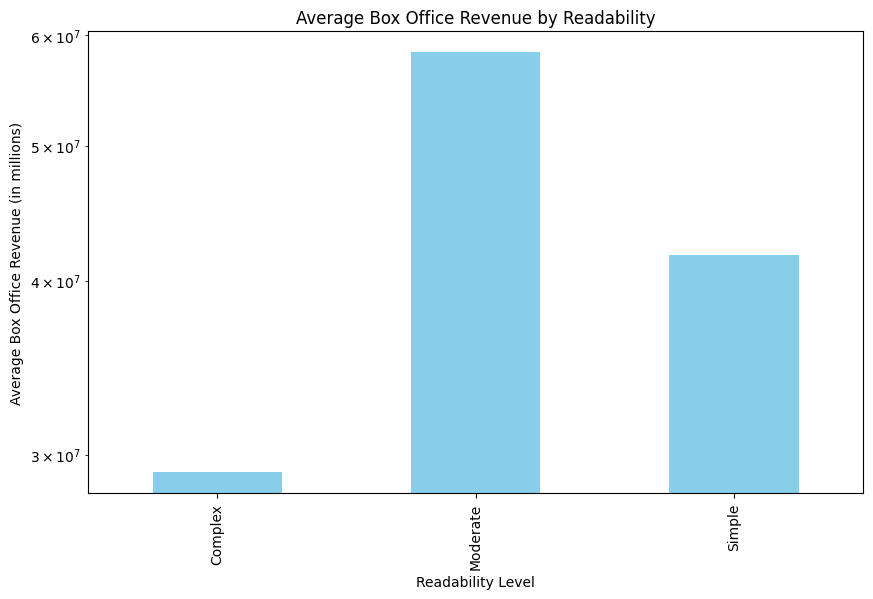

In [65]:
# Calculate Flesch Reading Ease Score
plot_merge['Readability'] = plot_merge['Plot'].apply(textstat.flesch_reading_ease)

# Create buckets for readability scores
plot_merge['Readability Bucket'] = pd.cut(plot_merge['Readability'], bins=[0, 50, 70, 100], labels=['Complex', 'Moderate', 'Simple'])

# Calculate average revenue and rating by readability bucket
avg_revenue_by_bucket = plot_merge.groupby('Readability Bucket')['Movie box office revenue'].mean()

# Plot average revenue by readability bucket
plt.figure(figsize=(10, 6))
avg_revenue_by_bucket.plot(kind='bar', color='skyblue')
plt.title('Average Box Office Revenue by Readability')
plt.xlabel('Readability Level')
plt.ylabel('Average Box Office Revenue (in millions)')
plt.yscale('log')
plt.show()


Using the Flesch Reading Ease Score, plot summaries were categorized into three readability levels: Complex, Moderate, and Simple. The bar chart reveals that movies with moderately readable plots tend to achieve the highest average revenue, while complex plots show the lowest. This trend suggests that audiences may prefer moderately complex storytelling, balancing engagement and accessibility, which could positively impact box office success.

# Divresity representation in the plot

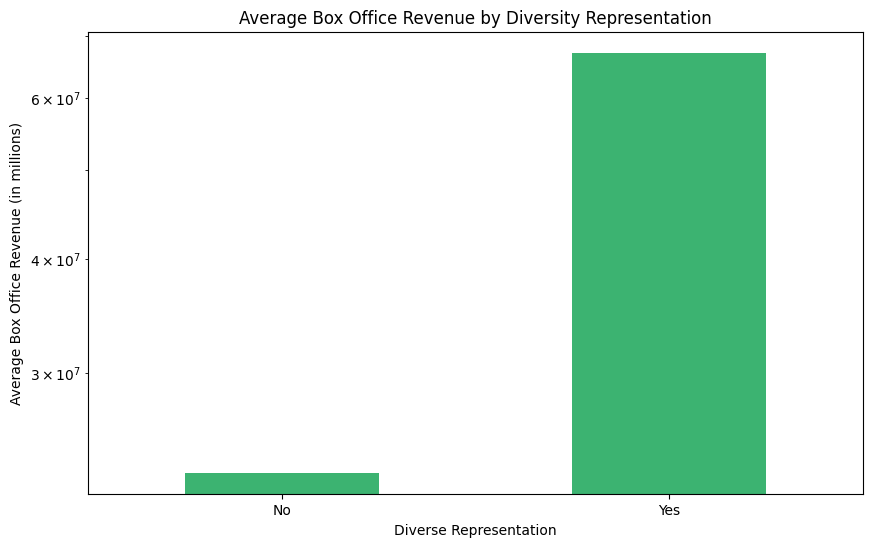

In [66]:
nlp = spacy.load('en_core_web_sm')

# Apply NER
plot_merge['Entities'] = plot_merge['Plot'].apply(lambda x : extract_entities(x, nlp))

# Flag movies with diverse characters and locations based on entity count
plot_merge['Diverse Representation'] = plot_merge['Entities'].apply(lambda x: len(x['characters']) > 3 and len(x['locations']) > 1)

# Calculate average revenue and rating for diverse vs non-diverse representation
avg_revenue_by_diversity = plot_merge.groupby('Diverse Representation')['Movie box office revenue'].mean()

# Plot average revenue by diversity representation
plt.figure(figsize=(10, 6))
avg_revenue_by_diversity.plot(kind='bar', color='mediumseagreen')
plt.title('Average Box Office Revenue by Diversity Representation')
plt.xlabel('Diverse Representation')
plt.ylabel('Average Box Office Revenue (in millions)')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.yscale('log')
plt.show()

This analysis evaluates the impact of diverse representation on box office revenue based on specific criteria derived from named entity recognition (NER). A movie is considered to have "diverse representation" if its plot features more than three unique characters and at least two distinct locations. Using these criteria, the bar chart shows that movies meeting this diversity threshold have significantly higher average box office revenue, suggesting that audiences may favor films with a broader array of characters and settings.

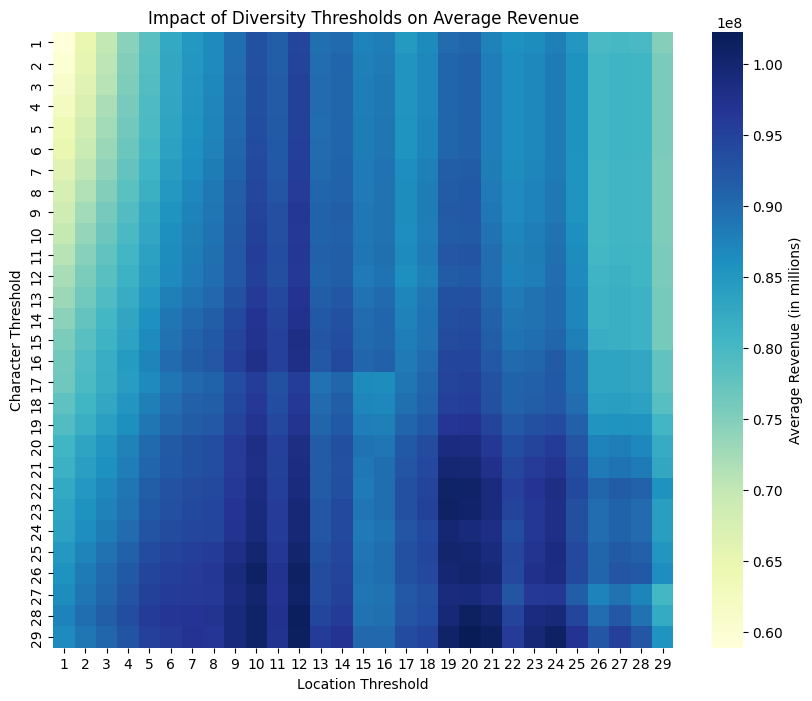

In [74]:
# Define a range of thresholds for characters and locations
character_thresholds = range(1, 30)  # Test thresholds 1 to 30 for characters
location_thresholds = range(1, 30)   # Test thresholds 1 to 30 for locations

# Store average revenue for each threshold combination
threshold_results = []

for char_thresh in character_thresholds:
    for loc_thresh in location_thresholds:
        # Flag movies as diverse based on current thresholds
        plot_merge['Diverse Representation'] = plot_merge['Entities'].apply(
            lambda x: len(x['characters']) >= char_thresh and len(x['locations']) >= loc_thresh
        )
        
        # Calculate average revenue for diverse vs non-diverse representation
        avg_revenue = plot_merge.groupby('Diverse Representation')['Movie box office revenue'].mean()
        
        # Store the results
        threshold_results.append({
            'Character Threshold': char_thresh,
            'Location Threshold': loc_thresh,
            'Diverse Average Revenue': avg_revenue.get(True, 0),
            'Non-Diverse Average Revenue': avg_revenue.get(False, 0),
        })

# Convert results to a DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Pivot the data for heatmap visualization (focus on diverse revenue)
# Corrected pivot operation
heatmap_data = threshold_df.pivot(
    index='Character Threshold',
    columns='Location Threshold',
    values='Diverse Average Revenue'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Revenue (in millions)'})
plt.title("Impact of Diversity Thresholds on Average Revenue")
plt.xlabel("Location Threshold")
plt.ylabel("Character Threshold")
plt.show()

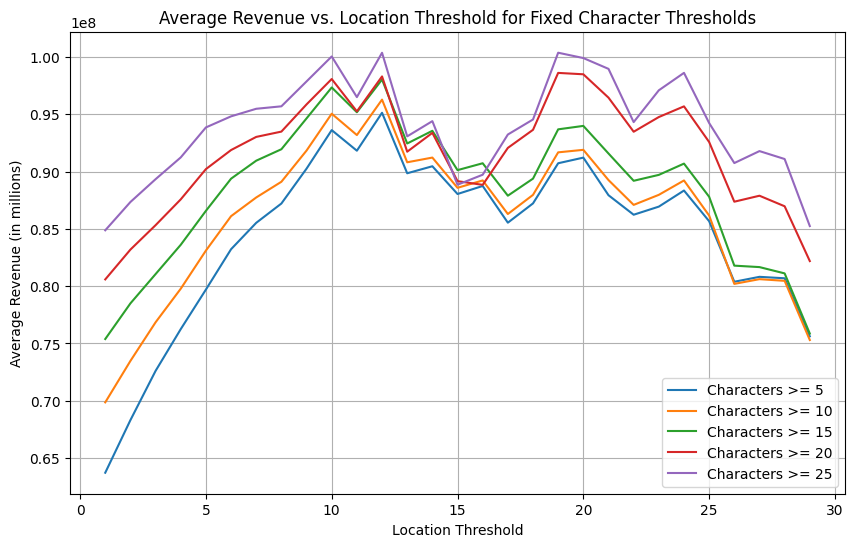

In [75]:
plt.figure(figsize=(10, 6))

# Plot for each fixed character threshold (example for thresholds 5, 10, 15)
for char_thresh in [5, 10, 15, 20, 25]:
    subset = threshold_df[threshold_df['Character Threshold'] == char_thresh]
    plt.plot(
        subset['Location Threshold'], 
        subset['Diverse Average Revenue'], 
        label=f"Characters >= {char_thresh}"
    )

plt.title("Average Revenue vs. Location Threshold for Fixed Character Thresholds")
plt.xlabel("Location Threshold")
plt.ylabel("Average Revenue (in millions)")
plt.legend()
plt.grid()
plt.show()


# Novelty

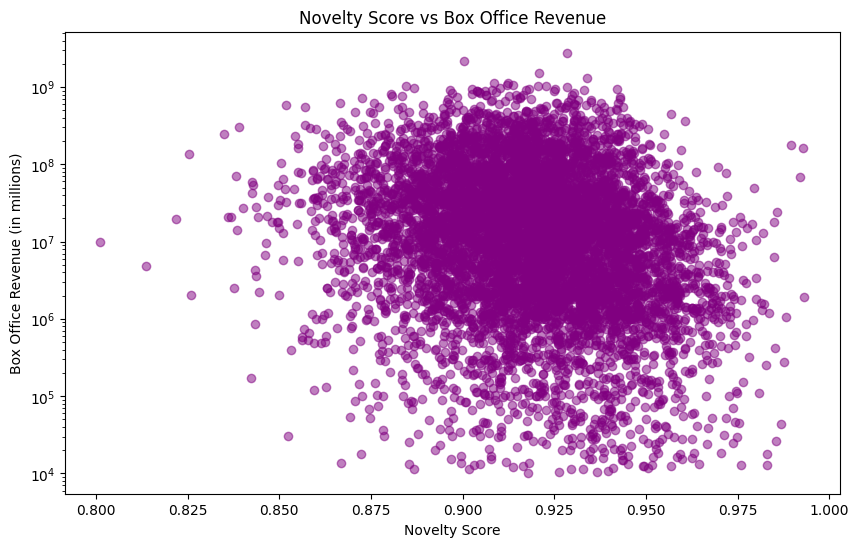

Correlation between Novelty Score and Box Office Revenue: -0.10505513836351195


In [67]:
# Vectorize plot summaries
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(plot_merge['Plot'])

# Calculate cosine similarity and measure uniqueness
cosine_similarities = cosine_similarity(tfidf_matrix)
average_similarity = cosine_similarities.mean(axis=1)  # Lower values indicate higher uniqueness
plot_merge['Novelty Score'] = 1 - average_similarity  # Novelty as (1 - avg similarity)

# Scatter plot of novelty score vs box office revenue
plt.figure(figsize=(10, 6))
plt.scatter(plot_merge['Novelty Score'], plot_merge['Movie box office revenue'], alpha=0.5, color='purple')
plt.title('Novelty Score vs Box Office Revenue')
plt.xlabel('Novelty Score')
plt.ylabel('Box Office Revenue (in millions)')
plt.yscale('log')
plt.show()

# Calculate the correlation between Novelty Score and Box Office Revenue
novelty_revenue_correlation = plot_merge['Novelty Score'].corr(plot_merge['Movie box office revenue'])
print(f"Correlation between Novelty Score and Box Office Revenue: {novelty_revenue_correlation}")


A correlation of −0.105 suggests a very weak negative relationship between the novelty of a movie's plot (as measured by the novelty score) and its box office revenue. This low value implies that plot novelty has minimal impact on revenue, indicating that highly unique or novel plot summaries do not necessarily lead to higher earnings.

# Random Forest

#### Data Handling

In [68]:
# Select relevant columns
columns_to_keep = ['release_date', 'runtime', 'original_language', 'genres', 'spoken_languages', 'keywords', 'net revenue']
tmdb_cleaned = tmdb[columns_to_keep].dropna()

# Extract month of release
tmdb_cleaned['release_date'] = pd.to_datetime(tmdb_cleaned['release_date'], errors='coerce')
tmdb_cleaned['release_month'] = tmdb_cleaned['release_date'].dt.month

# Extract primary genre (assume first listed genre as primary)
tmdb_cleaned['primary_genre'] = tmdb_cleaned['genres'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else 'Unknown')

# Count number of spoken languages and keywords
tmdb_cleaned['num_spoken_languages'] = tmdb_cleaned['spoken_languages'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
tmdb_cleaned['num_keywords'] = tmdb_cleaned['keywords'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Use frequency encoding for primary genre and original language
genre_counts = tmdb_cleaned['primary_genre'].value_counts().to_dict()
language_counts = tmdb_cleaned['original_language'].value_counts().to_dict()

tmdb_cleaned['primary_genre_encoded'] = tmdb_cleaned['primary_genre'].map(genre_counts)
tmdb_cleaned['original_language_encoded'] = tmdb_cleaned['original_language'].map(language_counts)

# Drop unused columns
tmdb_final = tmdb_cleaned.drop(columns=['release_date', 'genres', 'spoken_languages', 'keywords', 
                                        'primary_genre', 'original_language'])

# Define features and target
X = tmdb_final[['release_month', 'runtime', 'primary_genre_encoded', 'original_language_encoded', 
                'num_spoken_languages', 'num_keywords']]
y = tmdb_final['net revenue']


#### Train the model

In [69]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 14129347920573286.00
R² Score: 0.32


#### Plot the results

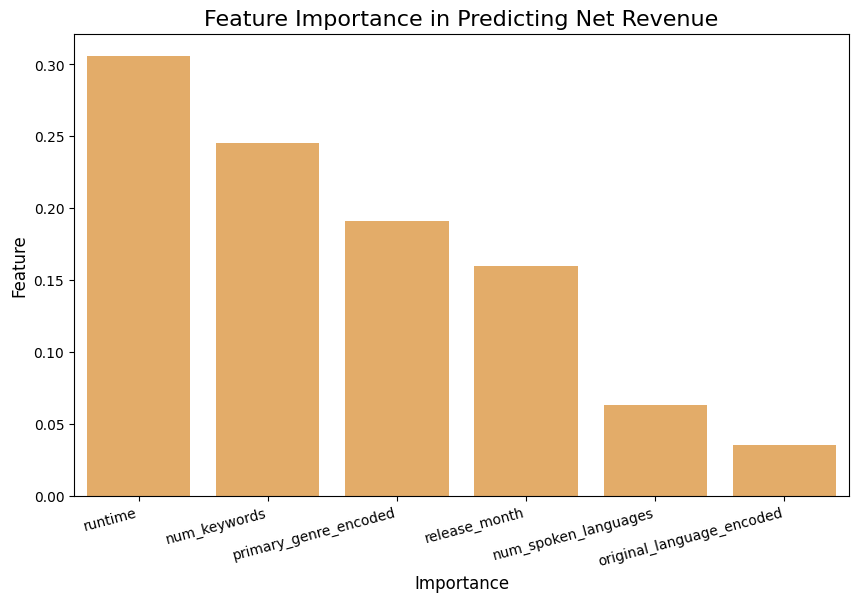

In [70]:
# Feature Importance
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, y='Importance', x='Feature', dodge=False, legend=False, color=GRAPH_COLORS[0])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Predicting Net Revenue', fontsize=16)
plt.xticks(rotation=15, ha='right')
plt.show()
